# HW1: Transfer Learning

Tufts CS 152 L3D, Fall 2024

Official Instructions: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html>

## Configuration

This assignment might take a while.
We recommend setting several variables here that prevent repeating long-running tasks.

In [1]:
device = 'cuda' # TODO change to GPU if you have one (e.g. on Colab)

PROB1_res_file = 'prob1_results.pkl'
PROB2_res_file = 'prob2_results.pkl'
PROB1_EXPERIMENTS = True  # Flag will skip re-running experiments if set to False
PROB1_PLOTS = True
PROB2_EXPERIMENTS = True
PROB2_PLOTS = True

# Environment setup

**Option 1: Colab**
To use this notebook with Google Colab, you will need an account and Google Drive storage (free tier just fine)

Please be sure you are *logged in* and have given requisite permission to access Drive to Google Colab.

The lines below will:

* Make folders called `CS152L3D_2024f/HW1/` in your google drive
* Clone the HW1 starter code repository there
* Note: Colab expects *this notebook* (or any notebook) will be in `Colab Notebooks/`.

That will let us use the starter code in this notebook.

**Option 2: Local**

You can also try to use your local machine (but if you don't have a GPU, this may be slow and painful.
If you choose this route, the lines below specific to Colab will just be skipped, and nothing will be done.

In [2]:
import sys
import os

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    COLAB = True
except ImportError:
    COLAB = False

In [4]:
if COLAB:
    if not os.path.exists(os.path.join('/content/drive/MyDrive/', 'CS152L3D_2024f')):
        !cd /content/drive/MyDrive/ && mkdir CS152L3D_2024f

In [5]:
# Move notebook working directory into the folder
if COLAB:
    %cd /content/drive/MyDrive/CS152L3D_2024f/

    # Clone the repo
    if not os.path.exists('cs152l3d-24f-assignments/hw1/'):
      !git clone https://github.com/tufts-ml-courses/cs152l3d-24f-assignments

    # cd into repo
    %cd cs152l3d-24f-assignments/hw1/

Check for success. We should be able to see files like

* model.py
* data_utils.py

In [6]:
!ls

README.md
__pycache__
best_model.pth
birdsnap10
birdsnap10_224x224only.zip
code_submission.zip
data_utils.py
documents
fine_tuned_model.pth
hw1.ipynb
hw1_template.tex
l3d_24f_cpu.yml
l3d_24f_cuda.yml
linear_probing_model.pth
models.py
prob1_results.pkl
resnet10-1253-88a5961b.pth
resnet10_cub-2777-4525b593.pth
resnet26-0849-4bfbc640.pth
resnet26_cub-2316-599ab467.pth
train.py


In [7]:
if COLAB:
    try:
        import torchinfo
        import pytorchcv
    except ImportError:
        rstr = '''
            torchinfo
            pytorchcv
            '''
        with open('colab_requirements.txt', 'w') as f:
            f.write(rstr)
        !pip install -r colab_requirements.txt
        import torchinfo
        import pytorchcv

In [8]:
DATA_DIR = os.environ.get('DATA_DIR', os.path.abspath('./birdsnap10'))
print(DATA_DIR)

c:\Users\josep\Code\School\L3D\Assignments\hw1\birdsnap10


In [9]:
if not os.path.exists(DATA_DIR):
    !unzip birdsnap10_224x224only.zip

In [10]:
# Show contents of train set
!ls $DATA_DIR/train/

American_Black_Duck
Golden_Eagle
Great_Horned_Owl
Harlequin_Duck
Osprey
Peregrine_Falcon
Prairie_Falcon
Short_eared_Owl
White_Ibis
White_faced_Ibis


# Import Libraries

In [11]:
# Import third-party library modules
import json
import pickle
import itertools
import tqdm
import itertools

In [12]:
import numpy as np
import pandas as pd

In [13]:
import torchinfo
import pytorchcv
import torch
import torchvision

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8') # pretty matplotlib plots
sns.set('notebook', style='whitegrid', font_scale=1.25)

# Import starter code modules from local files

Use **autoreload** so that any changes to these local files will be automatically reloaded into this nb

In [15]:
%load_ext autoreload
%autoreload 2

In [16]:
# Import utils from provided local starter code files
import data_utils
import models
import train

In [17]:
# Re-run this cell if you've made changes to your local file, but they aren't reflected in current nb kernel state
import importlib
importlib.reload(models);
importlib.reload(train);

# Show basic ResNet10 architecture

Load ResNet10. All layers trainable by default.

In [18]:
resnet10_in = models.PretrainedResNetForBirdSnap10(
    src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=1)

Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


Pretty-print layer-by-layer info

In [19]:
torchinfo.summary(resnet10_in, (1, 3, 224, 224),
                  row_settings=['var_names'],
                  col_names=["output_size", "num_params"],
                  col_width=18)

Layer (type (var_name))                                           Output Shape       Param #
PretrainedResNetForBirdSnap10 (PretrainedResNetForBirdSnap10)     [1, 10]            --
├─ResNet (model)                                                  [1, 10]            --
│    └─Sequential (features)                                      [1, 512, 1, 1]     --
│    │    └─ResInitBlock (init_block)                             [1, 64, 56, 56]    (9,536)
│    │    └─Sequential (stage1)                                   [1, 64, 56, 56]    (73,984)
│    │    └─Sequential (stage2)                                   [1, 128, 28, 28]   (230,144)
│    │    └─Sequential (stage3)                                   [1, 256, 14, 14]   (919,040)
│    │    └─Sequential (stage4)                                   [1, 512, 7, 7]     (3,673,088)
│    │    └─AvgPool2d (final_pool)                                [1, 512, 1, 1]     --
│    └─Linear (output)                                            [1, 10]        

# Load dataset

In [20]:
# Verify data has been extracted correctly and is accessible to load in PyTorch
data_utils.BirdsnapDataset(DATA_DIR)

Dataset BirdsnapDataset
    Number of datapoints: 640
    Root location: c:\Users\josep\Code\School\L3D\Assignments\hw1\birdsnap10

In [21]:
train_loader, val_loader, test_loader = data_utils.make_birdsnap_data_loaders(DATA_DIR)

splitname  0  1  2  3  4  5  6  7  8  9
    train 40 40 40 40 40 40 40 40 40 40
    valid 10 10 10 10 10 10 10 10 10 10
     test 14 14 14 14 14 14 14 14 14 14


# Problem 1 Implementation Tasks

In separate windows, you'll need to edit:

* models.py, see task (i) here: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html#problem1>
* train.py, see tasks (ii, iii, iv) here: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html#problem1>

Any edits to these files should *automatically* be reflected here in your active nb session, since we used **autoreload** above

Finally, as task (v), complete the implementation of `eval_acc` here to evaluate accuracy on test data

In [22]:
def eval_acc(model, device, test_loader):
    model.to(device)
    model.eval()
    correct = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)  # Move inputs and labels to the device
            logits = model(x)  # Forward pass to get predictions
            preds = torch.argmax(logits, dim=1)  # Get the predicted class
            correct += (preds == y).sum().item()  # Count the correct predictions
            # Count number of correct predictions across all batches of provided loader
    return correct / len(test_loader.dataset)

# Problem 1 Experiments

We'll now try to fit models for 2 archs (RN10, RN26) and 2 srcdatasets (ImageNet, CUB)

For each one, we'll

* keep n_trainable_layers = 1 ("last layer only" or "linear probing")
* Try to find reasonable settings of learning rate (lr), l2 penalty strength (l2pen_mag), and random seed (controls initialization and data order)

**TODO: Last-layer training of ResNet10 from ImageNet1k.**

Need to find good hyperparameters (seed, lr, l2penalty magnitude, n_epochs)

Don't peek at test, just use validation to tune.

In [23]:
if PROB1_EXPERIMENTS:
    # Define hyperparameter search space
    learning_rates = [0.0001, 0.001, 0.01, 0.1]
    l2pen_mags = [0.0001, 0.001, 0.01, 0.1]
    seeds = [42, 100, 123]
    epochs = [30, 50, 100]

    # Track best model
    best_val_loss = float('inf')
    best_hyperparams = None
    best_model = None

    # Loop through all combinations of hyperparameters
    for lr, l2pen_mag, seed, epoch in itertools.product(learning_rates, l2pen_mags, seeds, epochs):
        print(f"Training with lr={lr}, l2pen_mag={l2pen_mag}, seed={seed}, epoch={epoch}")
        
        # Set the seed
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        
        # Create model with specified seed
        resnet10_in = models.PretrainedResNetForBirdSnap10(
            src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=1, seed=seed
        )
        
        # Train the model
        current_model, current_info = train.train_model(
            resnet10_in, device, train_loader, val_loader,
            n_epochs=epoch,
            lr=lr,
            l2pen_mag=l2pen_mag,
            data_order_seed=seed
        )
        
        # Get validation loss from training info
        val_loss = min(current_info['va']['xent'])
        
        # Update the best model if the current one is better
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_hyperparams = {'lr': lr, 'l2pen_mag': l2pen_mag, 'seed': seed, 'epoch': epoch}
            best_model = current_model

    # Output the best hyperparameters and validation loss
    print(f"Best validation loss: {best_val_loss}")
    print(f"Best hyperparameters: {best_hyperparams}")

Training with lr=0.0001, l2pen_mag=0.0001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.14it/s, tr_xent=1.36, tr_err=0.285, va_xent=1.52, va_err=0.38, batch_done=7]
c:\Users\josep\miniconda3\envs\cs152_env\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Finished after epoch 30, best epoch=30
best va_xent 1.522
best tr_err 0.285
best va_err 0.380
Training with lr=0.0001, l2pen_mag=0.0001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:43<00:00,  1.16it/s, tr_xent=0.954, tr_err=0.152, va_xent=1.19, va_err=0.31, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.194
best tr_err 0.152
best va_err 0.310
Training with lr=0.0001, l2pen_mag=0.0001, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:29<00:00,  1.13it/s, tr_xent=0.553, tr_err=0.0575, va_xent=0.835, va_err=0.19, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 0.835
best tr_err 0.058
best va_err 0.190
Training with lr=0.0001, l2pen_mag=0.0001, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.15it/s, tr_xent=1.21, tr_err=0.242, va_xent=1.4, va_err=0.39, batch_done=7] 


Finished after epoch 30, best epoch=30
best va_xent 1.395
best tr_err 0.242
best va_err 0.390
Training with lr=0.0001, l2pen_mag=0.0001, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:45<00:00,  1.13it/s, tr_xent=0.9, tr_err=0.155, va_xent=1.11, va_err=0.29, batch_done=7]  


Finished after epoch 50, best epoch=50
best va_xent 1.114
best tr_err 0.155
best va_err 0.290
Training with lr=0.0001, l2pen_mag=0.0001, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:29<00:00,  1.13it/s, tr_xent=0.534, tr_err=0.0725, va_xent=0.778, va_err=0.18, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 0.778
best tr_err 0.072
best va_err 0.180
Training with lr=0.0001, l2pen_mag=0.0001, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.14it/s, tr_xent=1.24, tr_err=0.27, va_xent=1.42, va_err=0.4, batch_done=7]  


Finished after epoch 30, best epoch=30
best va_xent 1.419
best tr_err 0.270
best va_err 0.400
Training with lr=0.0001, l2pen_mag=0.0001, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:45<00:00,  1.13it/s, tr_xent=0.926, tr_err=0.172, va_xent=1.12, va_err=0.3, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.121
best tr_err 0.172
best va_err 0.300
Training with lr=0.0001, l2pen_mag=0.0001, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:30<00:00,  1.11it/s, tr_xent=0.51, tr_err=0.0675, va_xent=0.776, va_err=0.17, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 0.776
best tr_err 0.068
best va_err 0.170
Training with lr=0.0001, l2pen_mag=0.001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.15it/s, tr_xent=1.36, tr_err=0.285, va_xent=1.52, va_err=0.38, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.522
best tr_err 0.285
best va_err 0.380
Training with lr=0.0001, l2pen_mag=0.001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.14it/s, tr_xent=0.954, tr_err=0.152, va_xent=1.19, va_err=0.31, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.194
best tr_err 0.152
best va_err 0.310
Training with lr=0.0001, l2pen_mag=0.001, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:30<00:00,  1.12it/s, tr_xent=0.553, tr_err=0.0575, va_xent=0.835, va_err=0.19, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 0.835
best tr_err 0.058
best va_err 0.190
Training with lr=0.0001, l2pen_mag=0.001, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.13it/s, tr_xent=1.21, tr_err=0.242, va_xent=1.4, va_err=0.39, batch_done=7] 


Finished after epoch 30, best epoch=30
best va_xent 1.395
best tr_err 0.242
best va_err 0.390
Training with lr=0.0001, l2pen_mag=0.001, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:45<00:00,  1.12it/s, tr_xent=0.9, tr_err=0.155, va_xent=1.11, va_err=0.29, batch_done=7]  


Finished after epoch 50, best epoch=50
best va_xent 1.114
best tr_err 0.155
best va_err 0.290
Training with lr=0.0001, l2pen_mag=0.001, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:30<00:00,  1.12it/s, tr_xent=0.534, tr_err=0.0725, va_xent=0.778, va_err=0.18, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 0.778
best tr_err 0.072
best va_err 0.180
Training with lr=0.0001, l2pen_mag=0.001, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.14it/s, tr_xent=1.24, tr_err=0.27, va_xent=1.42, va_err=0.4, batch_done=7]  


Finished after epoch 30, best epoch=30
best va_xent 1.419
best tr_err 0.270
best va_err 0.400
Training with lr=0.0001, l2pen_mag=0.001, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:45<00:00,  1.12it/s, tr_xent=0.926, tr_err=0.172, va_xent=1.12, va_err=0.3, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.121
best tr_err 0.172
best va_err 0.300
Training with lr=0.0001, l2pen_mag=0.001, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:30<00:00,  1.12it/s, tr_xent=0.51, tr_err=0.0675, va_xent=0.776, va_err=0.17, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 0.776
best tr_err 0.068
best va_err 0.170
Training with lr=0.0001, l2pen_mag=0.01, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.14it/s, tr_xent=1.36, tr_err=0.285, va_xent=1.52, va_err=0.38, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.522
best tr_err 0.285
best va_err 0.380
Training with lr=0.0001, l2pen_mag=0.01, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:45<00:00,  1.13it/s, tr_xent=0.954, tr_err=0.152, va_xent=1.19, va_err=0.31, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.194
best tr_err 0.152
best va_err 0.310
Training with lr=0.0001, l2pen_mag=0.01, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:30<00:00,  1.12it/s, tr_xent=0.553, tr_err=0.0575, va_xent=0.835, va_err=0.19, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 0.835
best tr_err 0.058
best va_err 0.190
Training with lr=0.0001, l2pen_mag=0.01, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.14it/s, tr_xent=1.21, tr_err=0.242, va_xent=1.4, va_err=0.39, batch_done=7] 


Finished after epoch 30, best epoch=30
best va_xent 1.395
best tr_err 0.242
best va_err 0.390
Training with lr=0.0001, l2pen_mag=0.01, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:45<00:00,  1.12it/s, tr_xent=0.9, tr_err=0.155, va_xent=1.11, va_err=0.29, batch_done=7]  


Finished after epoch 50, best epoch=50
best va_xent 1.114
best tr_err 0.155
best va_err 0.290
Training with lr=0.0001, l2pen_mag=0.01, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:30<00:00,  1.12it/s, tr_xent=0.534, tr_err=0.0725, va_xent=0.778, va_err=0.18, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 0.778
best tr_err 0.072
best va_err 0.180
Training with lr=0.0001, l2pen_mag=0.01, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.14it/s, tr_xent=1.24, tr_err=0.27, va_xent=1.42, va_err=0.4, batch_done=7]  


Finished after epoch 30, best epoch=30
best va_xent 1.419
best tr_err 0.270
best va_err 0.400
Training with lr=0.0001, l2pen_mag=0.01, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:45<00:00,  1.13it/s, tr_xent=0.926, tr_err=0.172, va_xent=1.12, va_err=0.3, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.121
best tr_err 0.172
best va_err 0.300
Training with lr=0.0001, l2pen_mag=0.01, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:30<00:00,  1.12it/s, tr_xent=0.51, tr_err=0.0675, va_xent=0.776, va_err=0.17, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 0.776
best tr_err 0.068
best va_err 0.170
Training with lr=0.0001, l2pen_mag=0.1, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.13it/s, tr_xent=1.36, tr_err=0.285, va_xent=1.52, va_err=0.38, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.522
best tr_err 0.285
best va_err 0.380
Training with lr=0.0001, l2pen_mag=0.1, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:45<00:00,  1.13it/s, tr_xent=0.954, tr_err=0.152, va_xent=1.19, va_err=0.31, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.194
best tr_err 0.152
best va_err 0.310
Training with lr=0.0001, l2pen_mag=0.1, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:30<00:00,  1.12it/s, tr_xent=0.553, tr_err=0.0575, va_xent=0.835, va_err=0.19, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 0.835
best tr_err 0.058
best va_err 0.190
Training with lr=0.0001, l2pen_mag=0.1, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.14it/s, tr_xent=1.21, tr_err=0.242, va_xent=1.4, va_err=0.39, batch_done=7] 


Finished after epoch 30, best epoch=30
best va_xent 1.395
best tr_err 0.242
best va_err 0.390
Training with lr=0.0001, l2pen_mag=0.1, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:45<00:00,  1.13it/s, tr_xent=0.9, tr_err=0.155, va_xent=1.11, va_err=0.29, batch_done=7]  


Finished after epoch 50, best epoch=50
best va_xent 1.114
best tr_err 0.155
best va_err 0.290
Training with lr=0.0001, l2pen_mag=0.1, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:30<00:00,  1.12it/s, tr_xent=0.534, tr_err=0.0725, va_xent=0.778, va_err=0.18, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 0.778
best tr_err 0.072
best va_err 0.180
Training with lr=0.0001, l2pen_mag=0.1, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.14it/s, tr_xent=1.24, tr_err=0.27, va_xent=1.42, va_err=0.4, batch_done=7]  


Finished after epoch 30, best epoch=30
best va_xent 1.419
best tr_err 0.270
best va_err 0.400
Training with lr=0.0001, l2pen_mag=0.1, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:45<00:00,  1.13it/s, tr_xent=0.926, tr_err=0.172, va_xent=1.12, va_err=0.3, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.121
best tr_err 0.172
best va_err 0.300
Training with lr=0.0001, l2pen_mag=0.1, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:30<00:00,  1.12it/s, tr_xent=0.51, tr_err=0.0675, va_xent=0.776, va_err=0.17, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 0.776
best tr_err 0.068
best va_err 0.170
Training with lr=0.001, l2pen_mag=0.0001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.13it/s, tr_xent=0.197, tr_err=0.005, va_xent=0.52, va_err=0.14, batch_done=7]  


Finished after epoch 30, best epoch=29
best va_xent 0.512
best tr_err 0.010
best va_err 0.160
Training with lr=0.001, l2pen_mag=0.0001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.14it/s, tr_xent=0.0818, tr_err=0, va_xent=0.438, va_err=0.14, batch_done=7]    


Finished after epoch 50, best epoch=45
best va_xent 0.431
best tr_err 0.000
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.0001, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 87%|████████▋ | 88/101 [01:18<00:11,  1.13it/s, tr_xent=0.0414, tr_err=0, va_xent=0.397, va_err=0.12, batch_done=7]     


Stopped early.
Finished after epoch 88, best epoch=73
best va_xent 0.396
best tr_err 0.000
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.0001, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.14it/s, tr_xent=0.162, tr_err=0, va_xent=0.486, va_err=0.12, batch_done=7]     


Finished after epoch 30, best epoch=28
best va_xent 0.484
best tr_err 0.010
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.0001, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.14it/s, tr_xent=0.0899, tr_err=0.0025, va_xent=0.445, va_err=0.12, batch_done=7]


Finished after epoch 50, best epoch=49
best va_xent 0.435
best tr_err 0.003
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.0001, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:28<00:00,  1.14it/s, tr_xent=0.0309, tr_err=0, va_xent=0.4, va_err=0.1, batch_done=7]       


Finished after epoch 100, best epoch=91
best va_xent 0.389
best tr_err 0.000
best va_err 0.100
Training with lr=0.001, l2pen_mag=0.0001, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.13it/s, tr_xent=0.174, tr_err=0.0075, va_xent=0.479, va_err=0.1, batch_done=7] 


Finished after epoch 30, best epoch=29
best va_xent 0.479
best tr_err 0.007
best va_err 0.110
Training with lr=0.001, l2pen_mag=0.0001, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:45<00:00,  1.13it/s, tr_xent=0.0927, tr_err=0.0025, va_xent=0.43, va_err=0.11, batch_done=7]


Finished after epoch 50, best epoch=49
best va_xent 0.417
best tr_err 0.000
best va_err 0.090
Training with lr=0.001, l2pen_mag=0.0001, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 92%|█████████▏| 93/101 [01:22<00:07,  1.13it/s, tr_xent=0.0384, tr_err=0, va_xent=0.401, va_err=0.09, batch_done=7]     


Stopped early.
Finished after epoch 93, best epoch=78
best va_xent 0.388
best tr_err 0.000
best va_err 0.090
Training with lr=0.001, l2pen_mag=0.001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.14it/s, tr_xent=0.197, tr_err=0.005, va_xent=0.52, va_err=0.14, batch_done=7]  


Finished after epoch 30, best epoch=29
best va_xent 0.512
best tr_err 0.010
best va_err 0.160
Training with lr=0.001, l2pen_mag=0.001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.14it/s, tr_xent=0.0818, tr_err=0, va_xent=0.438, va_err=0.14, batch_done=7]    


Finished after epoch 50, best epoch=45
best va_xent 0.431
best tr_err 0.000
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.001, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 87%|████████▋ | 88/101 [01:18<00:11,  1.12it/s, tr_xent=0.0414, tr_err=0, va_xent=0.397, va_err=0.12, batch_done=7]     


Stopped early.
Finished after epoch 88, best epoch=73
best va_xent 0.396
best tr_err 0.000
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.001, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.14it/s, tr_xent=0.162, tr_err=0, va_xent=0.486, va_err=0.12, batch_done=7]     


Finished after epoch 30, best epoch=28
best va_xent 0.484
best tr_err 0.010
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.001, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.14it/s, tr_xent=0.0899, tr_err=0.0025, va_xent=0.445, va_err=0.12, batch_done=7]


Finished after epoch 50, best epoch=49
best va_xent 0.435
best tr_err 0.003
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.001, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:28<00:00,  1.14it/s, tr_xent=0.0309, tr_err=0, va_xent=0.4, va_err=0.1, batch_done=7]       


Finished after epoch 100, best epoch=91
best va_xent 0.389
best tr_err 0.000
best va_err 0.100
Training with lr=0.001, l2pen_mag=0.001, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.14it/s, tr_xent=0.174, tr_err=0.0075, va_xent=0.479, va_err=0.1, batch_done=7] 


Finished after epoch 30, best epoch=29
best va_xent 0.479
best tr_err 0.007
best va_err 0.110
Training with lr=0.001, l2pen_mag=0.001, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:45<00:00,  1.13it/s, tr_xent=0.0927, tr_err=0.0025, va_xent=0.43, va_err=0.11, batch_done=7]


Finished after epoch 50, best epoch=49
best va_xent 0.417
best tr_err 0.000
best va_err 0.090
Training with lr=0.001, l2pen_mag=0.001, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 92%|█████████▏| 93/101 [01:22<00:07,  1.13it/s, tr_xent=0.0384, tr_err=0, va_xent=0.401, va_err=0.09, batch_done=7]     


Stopped early.
Finished after epoch 93, best epoch=78
best va_xent 0.388
best tr_err 0.000
best va_err 0.090
Training with lr=0.001, l2pen_mag=0.01, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.14it/s, tr_xent=0.197, tr_err=0.005, va_xent=0.52, va_err=0.14, batch_done=7]  


Finished after epoch 30, best epoch=29
best va_xent 0.512
best tr_err 0.010
best va_err 0.160
Training with lr=0.001, l2pen_mag=0.01, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.14it/s, tr_xent=0.0818, tr_err=0, va_xent=0.438, va_err=0.14, batch_done=7]    


Finished after epoch 50, best epoch=45
best va_xent 0.431
best tr_err 0.000
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.01, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 87%|████████▋ | 88/101 [01:18<00:11,  1.13it/s, tr_xent=0.0414, tr_err=0, va_xent=0.397, va_err=0.12, batch_done=7]     


Stopped early.
Finished after epoch 88, best epoch=73
best va_xent 0.396
best tr_err 0.000
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.01, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.14it/s, tr_xent=0.162, tr_err=0, va_xent=0.486, va_err=0.12, batch_done=7]     


Finished after epoch 30, best epoch=28
best va_xent 0.484
best tr_err 0.010
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.01, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:45<00:00,  1.13it/s, tr_xent=0.0899, tr_err=0.0025, va_xent=0.445, va_err=0.12, batch_done=7]


Finished after epoch 50, best epoch=49
best va_xent 0.435
best tr_err 0.003
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.01, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:29<00:00,  1.13it/s, tr_xent=0.0309, tr_err=0, va_xent=0.4, va_err=0.1, batch_done=7]       


Finished after epoch 100, best epoch=91
best va_xent 0.389
best tr_err 0.000
best va_err 0.100
Training with lr=0.001, l2pen_mag=0.01, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.13it/s, tr_xent=0.174, tr_err=0.0075, va_xent=0.479, va_err=0.1, batch_done=7] 


Finished after epoch 30, best epoch=29
best va_xent 0.479
best tr_err 0.007
best va_err 0.110
Training with lr=0.001, l2pen_mag=0.01, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:45<00:00,  1.13it/s, tr_xent=0.0927, tr_err=0.0025, va_xent=0.43, va_err=0.11, batch_done=7]


Finished after epoch 50, best epoch=49
best va_xent 0.417
best tr_err 0.000
best va_err 0.090
Training with lr=0.001, l2pen_mag=0.01, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 92%|█████████▏| 93/101 [01:22<00:07,  1.13it/s, tr_xent=0.0384, tr_err=0, va_xent=0.401, va_err=0.09, batch_done=7]     


Stopped early.
Finished after epoch 93, best epoch=78
best va_xent 0.388
best tr_err 0.000
best va_err 0.090
Training with lr=0.001, l2pen_mag=0.1, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.14it/s, tr_xent=0.198, tr_err=0.005, va_xent=0.52, va_err=0.14, batch_done=7]  


Finished after epoch 30, best epoch=29
best va_xent 0.512
best tr_err 0.010
best va_err 0.160
Training with lr=0.001, l2pen_mag=0.1, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.14it/s, tr_xent=0.0818, tr_err=0, va_xent=0.438, va_err=0.14, batch_done=7]    


Finished after epoch 50, best epoch=45
best va_xent 0.431
best tr_err 0.000
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.1, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 87%|████████▋ | 88/101 [01:16<00:11,  1.14it/s, tr_xent=0.0414, tr_err=0, va_xent=0.397, va_err=0.12, batch_done=7]     


Stopped early.
Finished after epoch 88, best epoch=73
best va_xent 0.396
best tr_err 0.000
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.1, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.15it/s, tr_xent=0.162, tr_err=0, va_xent=0.486, va_err=0.12, batch_done=7]     


Finished after epoch 30, best epoch=28
best va_xent 0.485
best tr_err 0.010
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.1, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.15it/s, tr_xent=0.0899, tr_err=0.0025, va_xent=0.445, va_err=0.12, batch_done=7]


Finished after epoch 50, best epoch=49
best va_xent 0.435
best tr_err 0.003
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.1, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:25<00:00,  1.18it/s, tr_xent=0.0309, tr_err=0, va_xent=0.4, va_err=0.1, batch_done=7]       


Finished after epoch 100, best epoch=91
best va_xent 0.389
best tr_err 0.000
best va_err 0.100
Training with lr=0.001, l2pen_mag=0.1, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.17it/s, tr_xent=0.174, tr_err=0.0075, va_xent=0.479, va_err=0.1, batch_done=7] 


Finished after epoch 30, best epoch=29
best va_xent 0.479
best tr_err 0.007
best va_err 0.110
Training with lr=0.001, l2pen_mag=0.1, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.14it/s, tr_xent=0.0928, tr_err=0.0025, va_xent=0.43, va_err=0.11, batch_done=7]


Finished after epoch 50, best epoch=49
best va_xent 0.417
best tr_err 0.000
best va_err 0.090
Training with lr=0.001, l2pen_mag=0.1, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 92%|█████████▏| 93/101 [01:23<00:07,  1.12it/s, tr_xent=0.0385, tr_err=0, va_xent=0.401, va_err=0.09, batch_done=7]     


Stopped early.
Finished after epoch 93, best epoch=78
best va_xent 0.388
best tr_err 0.000
best va_err 0.090
Training with lr=0.01, l2pen_mag=0.0001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.18it/s, tr_xent=0.0251, tr_err=0, va_xent=0.397, va_err=0.12, batch_done=7]     


Finished after epoch 30, best epoch=23
best va_xent 0.371
best tr_err 0.000
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.0001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 37%|███▋      | 19/51 [00:16<00:27,  1.18it/s, tr_xent=0.037, tr_err=0, va_xent=0.408, va_err=0.13, batch_done=1]      


KeyboardInterrupt: 

In [27]:
if PROB1_EXPERIMENTS:
    seed = 42
    resnet10_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=1, seed=seed)
    best_model_rn10_in, best_info_rn10_in = train.train_model(resnet10_in, device, train_loader, val_loader,
        n_epochs=30,
        lr=0.01,
        l2pen_mag=0.001, # no L2 penalty on weight magnitude
        data_order_seed=seed,
        )
    best_info_rn10_in["lr"] = 0.01
    best_info_rn10_in["l2pen_mag"] = 0.001
    best_info_rn10_in["seed"] = 42

Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.16it/s, tr_xent=0.0251, tr_err=0, va_xent=0.397, va_err=0.12, batch_done=7]     

Finished after epoch 30, best epoch=23
best va_xent 0.371
best tr_err 0.000
best va_err 0.130


# Diagnostic plot: Error/loss vs epoch

The plot below is just a demo of what you can plot. Values won't represent correct operation of model training until you run the code implementation tasks, and start training for longer (adjust n_epochs > 15).

FYI: good practices already implemented info dict returned by train_model

* Report perf on val on given initial model (epoch=0), before making any updates
* Train perf metrics only kick in for epoch 1 and later (when we are doing updates)

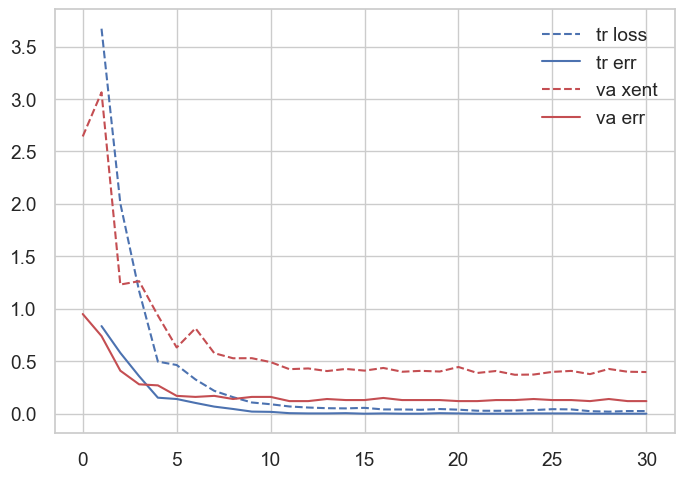

In [31]:
plt.plot(best_info_rn10_in['epochs'], best_info_rn10_in['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info_rn10_in['epochs'], best_info_rn10_in['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info_rn10_in['epochs'], best_info_rn10_in['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info_rn10_in['epochs'], best_info_rn10_in['va']['err'], '-', color='r', label='va err')
plt.legend();

**Pro Tip:** Consider storing your "best" runs to disk, using code like below

**TODO** repeat the above for each config in ('ResNet10', 'ResNet26') and ('ImageNet1k', 'CUB')

In [26]:
if PROB1_EXPERIMENTS:
    # Define hyperparameter search space
    learning_rates = [0.0001, 0.001, 0.01]
    l2pen_mags = [0.0001, 0.001, 0.01]
    seeds = [42, 100, 123]
    epochs = [30, 50, 100]

    # Track best model
    best_val_loss = float('inf')
    best_hyperparams = None
    best_model = None

    # Loop through all combinations of hyperparameters
    for lr, l2pen_mag, seed, epoch in itertools.product(learning_rates, l2pen_mags, seeds, epochs):
        print(f"Training with lr={lr}, l2pen_mag={l2pen_mag}, seed={seed}, epoch={epoch}")
        
        # Set the seed
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        
        # Create model with specified seed
        resnet10_in = models.PretrainedResNetForBirdSnap10(
            src_dataset='CUB', arch='ResNet10', n_trainable_layers=1, seed=seed
        )
        
        # Train the model
        current_model, current_info = train.train_model(
            resnet10_in, device, train_loader, val_loader,
            n_epochs=epoch,
            lr=lr,
            l2pen_mag=l2pen_mag,
            data_order_seed=seed
        )
        
        # Get validation loss from training info
        val_loss = min(current_info['va']['xent'])
        
        # Update the best model if the current one is better
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_hyperparams = {'lr': lr, 'l2pen_mag': l2pen_mag, 'seed': seed, 'epoch': epoch}
            best_model = current_model

    # Output the best hyperparameters and validation loss
    print(f"Best validation loss: {best_val_loss}")
    print(f"Best hyperparameters: {best_hyperparams}")

Training with lr=0.0001, l2pen_mag=0.0001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.17it/s, tr_xent=1.92, tr_err=0.417, va_xent=1.99, va_err=0.53, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.985
best tr_err 0.417
best va_err 0.530
Training with lr=0.0001, l2pen_mag=0.0001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:45<00:00,  1.12it/s, tr_xent=1.69, tr_err=0.312, va_xent=1.83, va_err=0.46, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.830
best tr_err 0.312
best va_err 0.460
Training with lr=0.0001, l2pen_mag=0.0001, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:28<00:00,  1.14it/s, tr_xent=1.34, tr_err=0.25, va_xent=1.55, va_err=0.42, batch_done=7] 


Finished after epoch 100, best epoch=100
best va_xent 1.554
best tr_err 0.250
best va_err 0.420
Training with lr=0.0001, l2pen_mag=0.0001, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.17it/s, tr_xent=1.89, tr_err=0.41, va_xent=2, va_err=0.52, batch_done=7]    


Finished after epoch 30, best epoch=30
best va_xent 2.000
best tr_err 0.410
best va_err 0.520
Training with lr=0.0001, l2pen_mag=0.0001, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.15it/s, tr_xent=1.67, tr_err=0.325, va_xent=1.84, va_err=0.48, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.835
best tr_err 0.325
best va_err 0.480
Training with lr=0.0001, l2pen_mag=0.0001, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:28<00:00,  1.14it/s, tr_xent=1.32, tr_err=0.265, va_xent=1.57, va_err=0.45, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 1.572
best tr_err 0.265
best va_err 0.450
Training with lr=0.0001, l2pen_mag=0.0001, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.16it/s, tr_xent=1.89, tr_err=0.385, va_xent=1.97, va_err=0.52, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.967
best tr_err 0.385
best va_err 0.520
Training with lr=0.0001, l2pen_mag=0.0001, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.15it/s, tr_xent=1.67, tr_err=0.292, va_xent=1.81, va_err=0.47, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.807
best tr_err 0.292
best va_err 0.470
Training with lr=0.0001, l2pen_mag=0.0001, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:28<00:00,  1.15it/s, tr_xent=1.32, tr_err=0.245, va_xent=1.55, va_err=0.42, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 1.549
best tr_err 0.245
best va_err 0.420
Training with lr=0.0001, l2pen_mag=0.001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.16it/s, tr_xent=1.92, tr_err=0.417, va_xent=1.99, va_err=0.53, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.985
best tr_err 0.417
best va_err 0.530
Training with lr=0.0001, l2pen_mag=0.001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.15it/s, tr_xent=1.69, tr_err=0.312, va_xent=1.83, va_err=0.46, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.830
best tr_err 0.312
best va_err 0.460
Training with lr=0.0001, l2pen_mag=0.001, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:28<00:00,  1.14it/s, tr_xent=1.34, tr_err=0.25, va_xent=1.55, va_err=0.42, batch_done=7] 


Finished after epoch 100, best epoch=100
best va_xent 1.554
best tr_err 0.250
best va_err 0.420
Training with lr=0.0001, l2pen_mag=0.001, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.15it/s, tr_xent=1.89, tr_err=0.41, va_xent=2, va_err=0.52, batch_done=7]    


Finished after epoch 30, best epoch=30
best va_xent 2.000
best tr_err 0.410
best va_err 0.520
Training with lr=0.0001, l2pen_mag=0.001, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.14it/s, tr_xent=1.67, tr_err=0.325, va_xent=1.84, va_err=0.48, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.835
best tr_err 0.325
best va_err 0.480
Training with lr=0.0001, l2pen_mag=0.001, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:28<00:00,  1.14it/s, tr_xent=1.32, tr_err=0.265, va_xent=1.57, va_err=0.45, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 1.572
best tr_err 0.265
best va_err 0.450
Training with lr=0.0001, l2pen_mag=0.001, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.16it/s, tr_xent=1.89, tr_err=0.385, va_xent=1.97, va_err=0.52, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.967
best tr_err 0.385
best va_err 0.520
Training with lr=0.0001, l2pen_mag=0.001, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.15it/s, tr_xent=1.67, tr_err=0.292, va_xent=1.81, va_err=0.47, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.807
best tr_err 0.292
best va_err 0.470
Training with lr=0.0001, l2pen_mag=0.001, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:27<00:00,  1.15it/s, tr_xent=1.32, tr_err=0.245, va_xent=1.55, va_err=0.42, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 1.549
best tr_err 0.245
best va_err 0.420
Training with lr=0.0001, l2pen_mag=0.01, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.16it/s, tr_xent=1.92, tr_err=0.417, va_xent=1.99, va_err=0.53, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.985
best tr_err 0.417
best va_err 0.530
Training with lr=0.0001, l2pen_mag=0.01, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:45<00:00,  1.12it/s, tr_xent=1.69, tr_err=0.312, va_xent=1.83, va_err=0.46, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.830
best tr_err 0.312
best va_err 0.460
Training with lr=0.0001, l2pen_mag=0.01, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:30<00:00,  1.11it/s, tr_xent=1.34, tr_err=0.25, va_xent=1.55, va_err=0.42, batch_done=7] 


Finished after epoch 100, best epoch=100
best va_xent 1.554
best tr_err 0.250
best va_err 0.420
Training with lr=0.0001, l2pen_mag=0.01, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.17it/s, tr_xent=1.89, tr_err=0.41, va_xent=2, va_err=0.52, batch_done=7]    


Finished after epoch 30, best epoch=30
best va_xent 2.000
best tr_err 0.410
best va_err 0.520
Training with lr=0.0001, l2pen_mag=0.01, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.14it/s, tr_xent=1.67, tr_err=0.325, va_xent=1.84, va_err=0.48, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.835
best tr_err 0.325
best va_err 0.480
Training with lr=0.0001, l2pen_mag=0.01, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:30<00:00,  1.12it/s, tr_xent=1.32, tr_err=0.265, va_xent=1.57, va_err=0.45, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 1.572
best tr_err 0.265
best va_err 0.450
Training with lr=0.0001, l2pen_mag=0.01, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.13it/s, tr_xent=1.89, tr_err=0.385, va_xent=1.97, va_err=0.52, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.967
best tr_err 0.385
best va_err 0.520
Training with lr=0.0001, l2pen_mag=0.01, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.14it/s, tr_xent=1.67, tr_err=0.292, va_xent=1.81, va_err=0.47, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.807
best tr_err 0.292
best va_err 0.470
Training with lr=0.0001, l2pen_mag=0.01, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:29<00:00,  1.13it/s, tr_xent=1.32, tr_err=0.245, va_xent=1.55, va_err=0.42, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 1.549
best tr_err 0.245
best va_err 0.420
Training with lr=0.001, l2pen_mag=0.0001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.15it/s, tr_xent=0.824, tr_err=0.182, va_xent=1.23, va_err=0.4, batch_done=7] 


Finished after epoch 30, best epoch=29
best va_xent 1.214
best tr_err 0.185
best va_err 0.430
Training with lr=0.001, l2pen_mag=0.0001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.14it/s, tr_xent=0.579, tr_err=0.115, va_xent=1.11, va_err=0.4, batch_done=7] 


Finished after epoch 50, best epoch=50
best va_xent 1.107
best tr_err 0.115
best va_err 0.400
Training with lr=0.001, l2pen_mag=0.0001, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:27<00:00,  1.16it/s, tr_xent=0.389, tr_err=0.0675, va_xent=0.993, va_err=0.32, batch_done=7]


Finished after epoch 100, best epoch=99
best va_xent 0.986
best tr_err 0.080
best va_err 0.330
Training with lr=0.001, l2pen_mag=0.0001, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.17it/s, tr_xent=0.771, tr_err=0.163, va_xent=1.21, va_err=0.42, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.211
best tr_err 0.163
best va_err 0.420
Training with lr=0.001, l2pen_mag=0.0001, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:43<00:00,  1.16it/s, tr_xent=0.574, tr_err=0.115, va_xent=1.1, va_err=0.39, batch_done=7] 


Finished after epoch 50, best epoch=50
best va_xent 1.102
best tr_err 0.115
best va_err 0.390
Training with lr=0.001, l2pen_mag=0.0001, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:28<00:00,  1.14it/s, tr_xent=0.369, tr_err=0.08, va_xent=0.975, va_err=0.33, batch_done=7] 


Finished after epoch 100, best epoch=100
best va_xent 0.975
best tr_err 0.080
best va_err 0.330
Training with lr=0.001, l2pen_mag=0.0001, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.17it/s, tr_xent=0.784, tr_err=0.177, va_xent=1.2, va_err=0.45, batch_done=7] 


Finished after epoch 30, best epoch=30
best va_xent 1.198
best tr_err 0.177
best va_err 0.450
Training with lr=0.001, l2pen_mag=0.0001, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:43<00:00,  1.16it/s, tr_xent=0.577, tr_err=0.138, va_xent=1.1, va_err=0.41, batch_done=7] 


Finished after epoch 50, best epoch=50
best va_xent 1.104
best tr_err 0.138
best va_err 0.410
Training with lr=0.001, l2pen_mag=0.0001, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:27<00:00,  1.16it/s, tr_xent=0.364, tr_err=0.0725, va_xent=0.989, va_err=0.33, batch_done=7]


Finished after epoch 100, best epoch=97
best va_xent 0.987
best tr_err 0.072
best va_err 0.330
Training with lr=0.001, l2pen_mag=0.001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.17it/s, tr_xent=0.824, tr_err=0.182, va_xent=1.23, va_err=0.4, batch_done=7] 


Finished after epoch 30, best epoch=29
best va_xent 1.214
best tr_err 0.185
best va_err 0.430
Training with lr=0.001, l2pen_mag=0.001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.15it/s, tr_xent=0.579, tr_err=0.115, va_xent=1.11, va_err=0.4, batch_done=7] 


Finished after epoch 50, best epoch=50
best va_xent 1.107
best tr_err 0.115
best va_err 0.400
Training with lr=0.001, l2pen_mag=0.001, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:26<00:00,  1.16it/s, tr_xent=0.389, tr_err=0.0675, va_xent=0.993, va_err=0.32, batch_done=7]


Finished after epoch 100, best epoch=99
best va_xent 0.986
best tr_err 0.080
best va_err 0.330
Training with lr=0.001, l2pen_mag=0.001, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.17it/s, tr_xent=0.771, tr_err=0.163, va_xent=1.21, va_err=0.42, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.211
best tr_err 0.163
best va_err 0.420
Training with lr=0.001, l2pen_mag=0.001, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.15it/s, tr_xent=0.574, tr_err=0.115, va_xent=1.1, va_err=0.39, batch_done=7] 


Finished after epoch 50, best epoch=50
best va_xent 1.102
best tr_err 0.115
best va_err 0.390
Training with lr=0.001, l2pen_mag=0.001, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:26<00:00,  1.17it/s, tr_xent=0.369, tr_err=0.08, va_xent=0.975, va_err=0.33, batch_done=7] 


Finished after epoch 100, best epoch=100
best va_xent 0.975
best tr_err 0.080
best va_err 0.330
Training with lr=0.001, l2pen_mag=0.001, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.16it/s, tr_xent=0.784, tr_err=0.177, va_xent=1.2, va_err=0.45, batch_done=7] 


Finished after epoch 30, best epoch=30
best va_xent 1.198
best tr_err 0.177
best va_err 0.450
Training with lr=0.001, l2pen_mag=0.001, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:43<00:00,  1.17it/s, tr_xent=0.577, tr_err=0.138, va_xent=1.1, va_err=0.41, batch_done=7] 


Finished after epoch 50, best epoch=50
best va_xent 1.104
best tr_err 0.138
best va_err 0.410
Training with lr=0.001, l2pen_mag=0.001, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:26<00:00,  1.16it/s, tr_xent=0.364, tr_err=0.0725, va_xent=0.989, va_err=0.33, batch_done=7]


Finished after epoch 100, best epoch=97
best va_xent 0.987
best tr_err 0.072
best va_err 0.330
Training with lr=0.001, l2pen_mag=0.01, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.17it/s, tr_xent=0.824, tr_err=0.182, va_xent=1.23, va_err=0.4, batch_done=7] 


Finished after epoch 30, best epoch=29
best va_xent 1.214
best tr_err 0.185
best va_err 0.430
Training with lr=0.001, l2pen_mag=0.01, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:43<00:00,  1.17it/s, tr_xent=0.579, tr_err=0.115, va_xent=1.11, va_err=0.4, batch_done=7] 


Finished after epoch 50, best epoch=50
best va_xent 1.107
best tr_err 0.115
best va_err 0.400
Training with lr=0.001, l2pen_mag=0.01, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:27<00:00,  1.16it/s, tr_xent=0.389, tr_err=0.0675, va_xent=0.993, va_err=0.32, batch_done=7]


Finished after epoch 100, best epoch=99
best va_xent 0.986
best tr_err 0.080
best va_err 0.330
Training with lr=0.001, l2pen_mag=0.01, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:27<00:00,  1.14it/s, tr_xent=0.771, tr_err=0.163, va_xent=1.21, va_err=0.42, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.211
best tr_err 0.163
best va_err 0.420
Training with lr=0.001, l2pen_mag=0.01, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:44<00:00,  1.16it/s, tr_xent=0.574, tr_err=0.115, va_xent=1.1, va_err=0.39, batch_done=7] 


Finished after epoch 50, best epoch=50
best va_xent 1.102
best tr_err 0.115
best va_err 0.390
Training with lr=0.001, l2pen_mag=0.01, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:26<00:00,  1.17it/s, tr_xent=0.369, tr_err=0.08, va_xent=0.975, va_err=0.33, batch_done=7] 


Finished after epoch 100, best epoch=100
best va_xent 0.975
best tr_err 0.080
best va_err 0.330
Training with lr=0.001, l2pen_mag=0.01, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.16it/s, tr_xent=0.784, tr_err=0.177, va_xent=1.2, va_err=0.45, batch_done=7] 


Finished after epoch 30, best epoch=30
best va_xent 1.198
best tr_err 0.177
best va_err 0.450
Training with lr=0.001, l2pen_mag=0.01, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:43<00:00,  1.16it/s, tr_xent=0.577, tr_err=0.138, va_xent=1.1, va_err=0.41, batch_done=7] 


Finished after epoch 50, best epoch=50
best va_xent 1.104
best tr_err 0.138
best va_err 0.410
Training with lr=0.001, l2pen_mag=0.01, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:26<00:00,  1.16it/s, tr_xent=0.364, tr_err=0.0725, va_xent=0.989, va_err=0.33, batch_done=7]


Finished after epoch 100, best epoch=97
best va_xent 0.987
best tr_err 0.072
best va_err 0.330
Training with lr=0.01, l2pen_mag=0.0001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.18it/s, tr_xent=0.288, tr_err=0.0825, va_xent=1.02, va_err=0.26, batch_done=7] 


Finished after epoch 30, best epoch=23
best va_xent 0.972
best tr_err 0.045
best va_err 0.310
Training with lr=0.01, l2pen_mag=0.0001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 75%|███████▍  | 38/51 [00:32<00:11,  1.15it/s, tr_xent=0.208, tr_err=0.0325, va_xent=1.03, va_err=0.27, batch_done=7] 


Stopped early.
Finished after epoch 38, best epoch=23
best va_xent 0.972
best tr_err 0.045
best va_err 0.310
Training with lr=0.01, l2pen_mag=0.0001, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 38%|███▊      | 38/101 [00:32<00:54,  1.16it/s, tr_xent=0.208, tr_err=0.0325, va_xent=1.03, va_err=0.27, batch_done=7] 


Stopped early.
Finished after epoch 38, best epoch=23
best va_xent 0.972
best tr_err 0.045
best va_err 0.310
Training with lr=0.01, l2pen_mag=0.0001, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:25<00:00,  1.20it/s, tr_xent=0.187, tr_err=0.0325, va_xent=0.938, va_err=0.29, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 0.938
best tr_err 0.033
best va_err 0.290
Training with lr=0.01, l2pen_mag=0.0001, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 88%|████████▊ | 45/51 [00:38<00:05,  1.16it/s, tr_xent=0.143, tr_err=0.01, va_xent=1.02, va_err=0.25, batch_done=7]   


Stopped early.
Finished after epoch 45, best epoch=30
best va_xent 0.938
best tr_err 0.033
best va_err 0.290
Training with lr=0.01, l2pen_mag=0.0001, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 45%|████▍     | 45/101 [00:38<00:48,  1.16it/s, tr_xent=0.143, tr_err=0.01, va_xent=1.02, va_err=0.25, batch_done=7]   


Stopped early.
Finished after epoch 45, best epoch=30
best va_xent 0.938
best tr_err 0.033
best va_err 0.290
Training with lr=0.01, l2pen_mag=0.0001, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.18it/s, tr_xent=0.22, tr_err=0.0475, va_xent=1.02, va_err=0.3, batch_done=7]   


Finished after epoch 30, best epoch=29
best va_xent 0.943
best tr_err 0.035
best va_err 0.280
Training with lr=0.01, l2pen_mag=0.0001, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 86%|████████▋ | 44/51 [00:37<00:06,  1.17it/s, tr_xent=0.14, tr_err=0.02, va_xent=1.09, va_err=0.29, batch_done=7]    


Stopped early.
Finished after epoch 44, best epoch=29
best va_xent 0.943
best tr_err 0.035
best va_err 0.280
Training with lr=0.01, l2pen_mag=0.0001, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 44%|████▎     | 44/101 [00:37<00:48,  1.16it/s, tr_xent=0.14, tr_err=0.02, va_xent=1.09, va_err=0.29, batch_done=7]    


Stopped early.
Finished after epoch 44, best epoch=29
best va_xent 0.943
best tr_err 0.035
best va_err 0.280
Training with lr=0.01, l2pen_mag=0.001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.19it/s, tr_xent=0.288, tr_err=0.0825, va_xent=1.02, va_err=0.26, batch_done=7] 


Finished after epoch 30, best epoch=23
best va_xent 0.972
best tr_err 0.045
best va_err 0.310
Training with lr=0.01, l2pen_mag=0.001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 75%|███████▍  | 38/51 [00:32<00:11,  1.15it/s, tr_xent=0.208, tr_err=0.0325, va_xent=1.03, va_err=0.27, batch_done=7] 


Stopped early.
Finished after epoch 38, best epoch=23
best va_xent 0.972
best tr_err 0.045
best va_err 0.310
Training with lr=0.01, l2pen_mag=0.001, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 38%|███▊      | 38/101 [00:32<00:54,  1.15it/s, tr_xent=0.208, tr_err=0.0325, va_xent=1.03, va_err=0.27, batch_done=7] 


Stopped early.
Finished after epoch 38, best epoch=23
best va_xent 0.972
best tr_err 0.045
best va_err 0.310
Training with lr=0.01, l2pen_mag=0.001, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.19it/s, tr_xent=0.187, tr_err=0.0325, va_xent=0.938, va_err=0.29, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 0.938
best tr_err 0.033
best va_err 0.290
Training with lr=0.01, l2pen_mag=0.001, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 88%|████████▊ | 45/51 [00:38<00:05,  1.16it/s, tr_xent=0.143, tr_err=0.01, va_xent=1.02, va_err=0.25, batch_done=7]   


Stopped early.
Finished after epoch 45, best epoch=30
best va_xent 0.938
best tr_err 0.033
best va_err 0.290
Training with lr=0.01, l2pen_mag=0.001, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 45%|████▍     | 45/101 [00:38<00:48,  1.16it/s, tr_xent=0.143, tr_err=0.01, va_xent=1.02, va_err=0.25, batch_done=7]   


Stopped early.
Finished after epoch 45, best epoch=30
best va_xent 0.938
best tr_err 0.033
best va_err 0.290
Training with lr=0.01, l2pen_mag=0.001, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.19it/s, tr_xent=0.22, tr_err=0.0475, va_xent=1.02, va_err=0.3, batch_done=7]   


Finished after epoch 30, best epoch=29
best va_xent 0.943
best tr_err 0.035
best va_err 0.280
Training with lr=0.01, l2pen_mag=0.001, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 86%|████████▋ | 44/51 [00:37<00:06,  1.16it/s, tr_xent=0.14, tr_err=0.02, va_xent=1.09, va_err=0.29, batch_done=7]    


Stopped early.
Finished after epoch 44, best epoch=29
best va_xent 0.943
best tr_err 0.035
best va_err 0.280
Training with lr=0.01, l2pen_mag=0.001, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 44%|████▎     | 44/101 [00:38<00:50,  1.14it/s, tr_xent=0.14, tr_err=0.02, va_xent=1.09, va_err=0.29, batch_done=7]    


Stopped early.
Finished after epoch 44, best epoch=29
best va_xent 0.943
best tr_err 0.035
best va_err 0.280
Training with lr=0.01, l2pen_mag=0.01, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.17it/s, tr_xent=0.288, tr_err=0.0825, va_xent=1.02, va_err=0.26, batch_done=7] 


Finished after epoch 30, best epoch=23
best va_xent 0.972
best tr_err 0.045
best va_err 0.310
Training with lr=0.01, l2pen_mag=0.01, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 75%|███████▍  | 38/51 [00:33<00:11,  1.15it/s, tr_xent=0.208, tr_err=0.0325, va_xent=1.03, va_err=0.27, batch_done=7] 


Stopped early.
Finished after epoch 38, best epoch=23
best va_xent 0.972
best tr_err 0.045
best va_err 0.310
Training with lr=0.01, l2pen_mag=0.01, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 38%|███▊      | 38/101 [00:32<00:54,  1.15it/s, tr_xent=0.208, tr_err=0.0325, va_xent=1.03, va_err=0.27, batch_done=7] 


Stopped early.
Finished after epoch 38, best epoch=23
best va_xent 0.972
best tr_err 0.045
best va_err 0.310
Training with lr=0.01, l2pen_mag=0.01, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:25<00:00,  1.19it/s, tr_xent=0.187, tr_err=0.0325, va_xent=0.938, va_err=0.29, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 0.938
best tr_err 0.033
best va_err 0.290
Training with lr=0.01, l2pen_mag=0.01, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 88%|████████▊ | 45/51 [00:39<00:05,  1.14it/s, tr_xent=0.143, tr_err=0.01, va_xent=1.02, va_err=0.25, batch_done=7]   


Stopped early.
Finished after epoch 45, best epoch=30
best va_xent 0.938
best tr_err 0.033
best va_err 0.290
Training with lr=0.01, l2pen_mag=0.01, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 45%|████▍     | 45/101 [00:39<00:48,  1.14it/s, tr_xent=0.143, tr_err=0.01, va_xent=1.02, va_err=0.25, batch_done=7]   


Stopped early.
Finished after epoch 45, best epoch=30
best va_xent 0.938
best tr_err 0.033
best va_err 0.290
Training with lr=0.01, l2pen_mag=0.01, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:26<00:00,  1.18it/s, tr_xent=0.22, tr_err=0.0475, va_xent=1.02, va_err=0.3, batch_done=7]   


Finished after epoch 30, best epoch=29
best va_xent 0.943
best tr_err 0.035
best va_err 0.280
Training with lr=0.01, l2pen_mag=0.01, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 86%|████████▋ | 44/51 [00:38<00:06,  1.15it/s, tr_xent=0.14, tr_err=0.02, va_xent=1.09, va_err=0.29, batch_done=7]    


Stopped early.
Finished after epoch 44, best epoch=29
best va_xent 0.943
best tr_err 0.035
best va_err 0.280
Training with lr=0.01, l2pen_mag=0.01, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 44%|████▎     | 44/101 [00:38<00:49,  1.16it/s, tr_xent=0.14, tr_err=0.02, va_xent=1.09, va_err=0.29, batch_done=7]    


Stopped early.
Finished after epoch 44, best epoch=29
best va_xent 0.943
best tr_err 0.035
best va_err 0.280
Best validation loss: 0.938299674987793
Best hyperparameters: {'lr': 0.01, 'l2pen_mag': 0.01, 'seed': 100, 'epoch': 30}


In [29]:
# TODO do tuning expts for Resnet10, CUB
if PROB1_EXPERIMENTS:
    seed = 100
    resnet10_cub = models.PretrainedResNetForBirdSnap10(
        src_dataset='CUB', arch='ResNet10', n_trainable_layers=1, seed=seed)
    best_model_rn10_cub, best_info_rn10_cub = train.train_model(resnet10_cub, device, train_loader, val_loader,
        n_epochs=30,
        lr=0.01,
        l2pen_mag=0.01, # no L2 penalty on weight magnitude
        data_order_seed=seed,
        )
    best_info_rn10_cub['lr'] = 0.01
    best_info_rn10_cub['l2pen_mag'] = 0.01
    best_info_rn10_cub['seed'] = seed

Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 88%|████████▊ | 45/51 [00:40<00:05,  1.12it/s, tr_xent=0.143, tr_err=0.01, va_xent=1.02, va_err=0.25, batch_done=7]   

Stopped early.
Finished after epoch 45, best epoch=30
best va_xent 0.938
best tr_err 0.033
best va_err 0.290


In [24]:
if PROB1_EXPERIMENTS:
    # Define hyperparameter search space
    learning_rates = [0.001, 0.01]
    l2pen_mags = [0.001, 0.01]
    seeds = [42, 100]
    epochs = [30, 50]

    # Track best model
    best_val_loss = float('inf')
    best_hyperparams = None
    best_model = None

    # Loop through all combinations of hyperparameters
    for lr, l2pen_mag, seed, epoch in itertools.product(learning_rates, l2pen_mags, seeds, epochs):
        print(f"Training with lr={lr}, l2pen_mag={l2pen_mag}, seed={seed}, epoch={epoch}")
        
        # Set the seed
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        
        # Create model with specified seed
        resnet10_in = models.PretrainedResNetForBirdSnap10(
            src_dataset='ImageNet1k', arch='ResNet26', n_trainable_layers=1, seed=seed
        )
        
        # Train the model
        current_model, current_info = train.train_model(
            resnet10_in, device, train_loader, val_loader,
            n_epochs=epoch,
            lr=lr,
            l2pen_mag=l2pen_mag,
            data_order_seed=seed
        )
        
        # Get validation loss from training info
        val_loss = min(current_info['va']['xent'])
        
        # Update the best model if the current one is better
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_hyperparams = {'lr': lr, 'l2pen_mag': l2pen_mag, 'seed': seed, 'epoch': epoch}
            best_model = current_model

    # Output the best hyperparameters and validation loss
    print(f"Best validation loss: {best_val_loss}")
    print(f"Best hyperparameters: {best_hyperparams}")

Training with lr=0.001, l2pen_mag=0.001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:29<00:00,  1.04it/s, tr_xent=0.209, tr_err=0.0075, va_xent=0.573, va_err=0.14, batch_done=7]


Finished after epoch 30, best epoch=29
best va_xent 0.571
best tr_err 0.007
best va_err 0.150
Training with lr=0.001, l2pen_mag=0.001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:48<00:00,  1.05it/s, tr_xent=0.107, tr_err=0.0025, va_xent=0.531, va_err=0.15, batch_done=7]


Finished after epoch 50, best epoch=47
best va_xent 0.518
best tr_err 0.000
best va_err 0.130
Training with lr=0.001, l2pen_mag=0.001, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:29<00:00,  1.04it/s, tr_xent=0.172, tr_err=0.0025, va_xent=0.564, va_err=0.15, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 0.564
best tr_err 0.003
best va_err 0.150
Training with lr=0.001, l2pen_mag=0.001, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:54<00:00,  1.08s/it, tr_xent=0.0911, tr_err=0, va_xent=0.541, va_err=0.14, batch_done=7]    


Finished after epoch 50, best epoch=48
best va_xent 0.520
best tr_err 0.000
best va_err 0.140
Training with lr=0.001, l2pen_mag=0.01, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:31<00:00,  1.01s/it, tr_xent=0.209, tr_err=0.0075, va_xent=0.573, va_err=0.14, batch_done=7]


Finished after epoch 30, best epoch=29
best va_xent 0.571
best tr_err 0.007
best va_err 0.150
Training with lr=0.001, l2pen_mag=0.01, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:55<00:00,  1.09s/it, tr_xent=0.107, tr_err=0.0025, va_xent=0.531, va_err=0.15, batch_done=7]


Finished after epoch 50, best epoch=47
best va_xent 0.518
best tr_err 0.000
best va_err 0.130
Training with lr=0.001, l2pen_mag=0.01, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:34<00:00,  1.11s/it, tr_xent=0.172, tr_err=0.0025, va_xent=0.564, va_err=0.15, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 0.564
best tr_err 0.003
best va_err 0.150
Training with lr=0.001, l2pen_mag=0.01, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 65%|██████▍   | 33/51 [00:36<00:20,  1.12s/it, tr_xent=0.184, tr_err=0.0075, va_xent=0.56, va_err=0.16, batch_done=5] 


KeyboardInterrupt: 

In [26]:
# TODO do tuning expts for Resnet26, ImageNet1k
if PROB1_EXPERIMENTS:
    seed = 123
    resnet26_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='ImageNet1k', arch='ResNet26', n_trainable_layers=1, seed=seed)
    best_model_rn26_in, best_info_rn26_in = train.train_model(resnet26_in, device, train_loader, val_loader,
        n_epochs=100,
        lr=0.001,
        l2pen_mag=0.0001, # no L2 penalty on weight magnitude
        data_order_seed=seed,
        )
    best_info_rn26_in['lr'] = 0.001
    best_info_rn26_in['l2pen_mag'] = 0.0001
    best_info_rn26_in['seed'] = seed


Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 74%|███████▍  | 75/101 [01:20<00:28,  1.08s/it, tr_xent=0.0577, tr_err=0, va_xent=0.476, va_err=0.14, batch_done=7]    

Stopped early.
Finished after epoch 75, best epoch=60
best va_xent 0.474
best tr_err 0.000
best va_err 0.130


In [28]:

if PROB1_EXPERIMENTS:
    # Define hyperparameter search space
    learning_rates = [0.0001, 0.001, 0.01]
    l2pen_mags = [0.0001, 0.001, 0.01]
    seeds = [42, 100, 123]
    epochs = [30, 50, 100]

    # Track best model
    best_val_loss = float('inf')
    best_hyperparams = None
    best_model = None

    # Loop through all combinations of hyperparameters
    for lr, l2pen_mag, seed, epoch in itertools.product(learning_rates, l2pen_mags, seeds, epochs):
        print(f"Training with lr={lr}, l2pen_mag={l2pen_mag}, seed={seed}, epoch={epoch}")
        
        # Set the seed
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        
        # Create model with specified seed
        resnet10_in = models.PretrainedResNetForBirdSnap10(
            src_dataset='CUB', arch='ResNet26', n_trainable_layers=1, seed=seed
        )
        
        # Train the model
        current_model, current_info = train.train_model(
            resnet10_in, device, train_loader, val_loader,
            n_epochs=epoch,
            lr=lr,
            l2pen_mag=l2pen_mag,
            data_order_seed=seed
        )
        
        # Get validation loss from training info
        val_loss = min(current_info['va']['xent'])
        
        # Update the best model if the current one is better
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_hyperparams = {'lr': lr, 'l2pen_mag': l2pen_mag, 'seed': seed, 'epoch': epoch}
            best_model = current_model

    # Output the best hyperparameters and validation loss
    print(f"Best validation loss: {best_val_loss}")
    print(f"Best hyperparameters: {best_hyperparams}")

Training with lr=0.0001, l2pen_mag=0.0001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:29<00:00,  1.07it/s, tr_xent=1.81, tr_err=0.343, va_xent=1.9, va_err=0.43, batch_done=7] 


Finished after epoch 30, best epoch=30
best va_xent 1.895
best tr_err 0.343
best va_err 0.430
Training with lr=0.0001, l2pen_mag=0.0001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:48<00:00,  1.05it/s, tr_xent=1.56, tr_err=0.258, va_xent=1.71, va_err=0.37, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.706
best tr_err 0.258
best va_err 0.370
Training with lr=0.0001, l2pen_mag=0.0001, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:36<00:00,  1.05it/s, tr_xent=1.21, tr_err=0.215, va_xent=1.4, va_err=0.34, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 1.402
best tr_err 0.215
best va_err 0.340
Training with lr=0.0001, l2pen_mag=0.0001, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:29<00:00,  1.06it/s, tr_xent=1.81, tr_err=0.372, va_xent=1.92, va_err=0.43, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.915
best tr_err 0.372
best va_err 0.430
Training with lr=0.0001, l2pen_mag=0.0001, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:49<00:00,  1.04it/s, tr_xent=1.56, tr_err=0.297, va_xent=1.72, va_err=0.41, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.719
best tr_err 0.297
best va_err 0.410
Training with lr=0.0001, l2pen_mag=0.0001, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:35<00:00,  1.05it/s, tr_xent=1.18, tr_err=0.228, va_xent=1.41, va_err=0.36, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 1.412
best tr_err 0.228
best va_err 0.360
Training with lr=0.0001, l2pen_mag=0.0001, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:29<00:00,  1.07it/s, tr_xent=1.84, tr_err=0.393, va_xent=1.93, va_err=0.46, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.927
best tr_err 0.393
best va_err 0.460
Training with lr=0.0001, l2pen_mag=0.0001, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:48<00:00,  1.06it/s, tr_xent=1.58, tr_err=0.263, va_xent=1.74, va_err=0.45, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.736
best tr_err 0.263
best va_err 0.450
Training with lr=0.0001, l2pen_mag=0.0001, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:35<00:00,  1.05it/s, tr_xent=1.19, tr_err=0.2, va_xent=1.42, va_err=0.33, batch_done=7]  


Finished after epoch 100, best epoch=100
best va_xent 1.422
best tr_err 0.200
best va_err 0.330
Training with lr=0.0001, l2pen_mag=0.001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:28<00:00,  1.07it/s, tr_xent=1.81, tr_err=0.343, va_xent=1.9, va_err=0.43, batch_done=7] 


Finished after epoch 30, best epoch=30
best va_xent 1.895
best tr_err 0.343
best va_err 0.430
Training with lr=0.0001, l2pen_mag=0.001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:48<00:00,  1.05it/s, tr_xent=1.56, tr_err=0.258, va_xent=1.71, va_err=0.37, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.706
best tr_err 0.258
best va_err 0.370
Training with lr=0.0001, l2pen_mag=0.001, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:36<00:00,  1.05it/s, tr_xent=1.21, tr_err=0.215, va_xent=1.4, va_err=0.34, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 1.402
best tr_err 0.215
best va_err 0.340
Training with lr=0.0001, l2pen_mag=0.001, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:28<00:00,  1.07it/s, tr_xent=1.81, tr_err=0.372, va_xent=1.92, va_err=0.43, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.915
best tr_err 0.372
best va_err 0.430
Training with lr=0.0001, l2pen_mag=0.001, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:48<00:00,  1.06it/s, tr_xent=1.56, tr_err=0.297, va_xent=1.72, va_err=0.41, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.719
best tr_err 0.297
best va_err 0.410
Training with lr=0.0001, l2pen_mag=0.001, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:38<00:00,  1.03it/s, tr_xent=1.18, tr_err=0.228, va_xent=1.41, va_err=0.36, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 1.412
best tr_err 0.228
best va_err 0.360
Training with lr=0.0001, l2pen_mag=0.001, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:29<00:00,  1.07it/s, tr_xent=1.84, tr_err=0.393, va_xent=1.93, va_err=0.46, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.927
best tr_err 0.393
best va_err 0.460
Training with lr=0.0001, l2pen_mag=0.001, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:49<00:00,  1.02it/s, tr_xent=1.58, tr_err=0.263, va_xent=1.74, va_err=0.45, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.736
best tr_err 0.263
best va_err 0.450
Training with lr=0.0001, l2pen_mag=0.001, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:40<00:00,  1.00it/s, tr_xent=1.19, tr_err=0.2, va_xent=1.42, va_err=0.33, batch_done=7]  


Finished after epoch 100, best epoch=100
best va_xent 1.422
best tr_err 0.200
best va_err 0.330
Training with lr=0.0001, l2pen_mag=0.01, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:30<00:00,  1.00it/s, tr_xent=1.81, tr_err=0.343, va_xent=1.9, va_err=0.43, batch_done=7] 


Finished after epoch 30, best epoch=30
best va_xent 1.895
best tr_err 0.343
best va_err 0.430
Training with lr=0.0001, l2pen_mag=0.01, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:50<00:00,  1.01it/s, tr_xent=1.56, tr_err=0.258, va_xent=1.71, va_err=0.37, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.706
best tr_err 0.258
best va_err 0.370
Training with lr=0.0001, l2pen_mag=0.01, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:39<00:00,  1.01it/s, tr_xent=1.21, tr_err=0.215, va_xent=1.4, va_err=0.34, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 1.402
best tr_err 0.215
best va_err 0.340
Training with lr=0.0001, l2pen_mag=0.01, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:29<00:00,  1.05it/s, tr_xent=1.81, tr_err=0.372, va_xent=1.92, va_err=0.43, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.915
best tr_err 0.372
best va_err 0.430
Training with lr=0.0001, l2pen_mag=0.01, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:49<00:00,  1.04it/s, tr_xent=1.56, tr_err=0.297, va_xent=1.72, va_err=0.41, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.719
best tr_err 0.297
best va_err 0.410
Training with lr=0.0001, l2pen_mag=0.01, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:36<00:00,  1.04it/s, tr_xent=1.18, tr_err=0.228, va_xent=1.41, va_err=0.36, batch_done=7]


Finished after epoch 100, best epoch=100
best va_xent 1.412
best tr_err 0.228
best va_err 0.360
Training with lr=0.0001, l2pen_mag=0.01, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:28<00:00,  1.07it/s, tr_xent=1.84, tr_err=0.393, va_xent=1.93, va_err=0.46, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.927
best tr_err 0.393
best va_err 0.460
Training with lr=0.0001, l2pen_mag=0.01, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:48<00:00,  1.06it/s, tr_xent=1.58, tr_err=0.263, va_xent=1.74, va_err=0.45, batch_done=7]


Finished after epoch 50, best epoch=50
best va_xent 1.736
best tr_err 0.263
best va_err 0.450
Training with lr=0.0001, l2pen_mag=0.01, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:36<00:00,  1.05it/s, tr_xent=1.19, tr_err=0.2, va_xent=1.42, va_err=0.33, batch_done=7]  


Finished after epoch 100, best epoch=100
best va_xent 1.422
best tr_err 0.200
best va_err 0.330
Training with lr=0.001, l2pen_mag=0.0001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:29<00:00,  1.06it/s, tr_xent=0.702, tr_err=0.152, va_xent=1.04, va_err=0.28, batch_done=7]


Finished after epoch 30, best epoch=29
best va_xent 1.029
best tr_err 0.155
best va_err 0.290
Training with lr=0.001, l2pen_mag=0.0001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:48<00:00,  1.06it/s, tr_xent=0.482, tr_err=0.07, va_xent=0.921, va_err=0.22, batch_done=7] 


Finished after epoch 50, best epoch=50
best va_xent 0.921
best tr_err 0.070
best va_err 0.220
Training with lr=0.001, l2pen_mag=0.0001, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:33<00:00,  1.08it/s, tr_xent=0.346, tr_err=0.05, va_xent=0.848, va_err=0.21, batch_done=7] 


Finished after epoch 100, best epoch=90
best va_xent 0.835
best tr_err 0.050
best va_err 0.210
Training with lr=0.001, l2pen_mag=0.0001, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:29<00:00,  1.03it/s, tr_xent=0.664, tr_err=0.115, va_xent=1.04, va_err=0.3, batch_done=7] 


Finished after epoch 30, best epoch=30
best va_xent 1.035
best tr_err 0.115
best va_err 0.300
Training with lr=0.001, l2pen_mag=0.0001, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:48<00:00,  1.05it/s, tr_xent=0.477, tr_err=0.09, va_xent=0.934, va_err=0.24, batch_done=7]  


Finished after epoch 50, best epoch=50
best va_xent 0.934
best tr_err 0.090
best va_err 0.240
Training with lr=0.001, l2pen_mag=0.0001, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:34<00:00,  1.07it/s, tr_xent=0.296, tr_err=0.045, va_xent=0.855, va_err=0.19, batch_done=7]


Finished after epoch 100, best epoch=90
best va_xent 0.848
best tr_err 0.050
best va_err 0.230
Training with lr=0.001, l2pen_mag=0.0001, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:30<00:00,  1.03it/s, tr_xent=0.654, tr_err=0.145, va_xent=1.03, va_err=0.29, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.034
best tr_err 0.145
best va_err 0.290
Training with lr=0.001, l2pen_mag=0.0001, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:49<00:00,  1.03it/s, tr_xent=0.487, tr_err=0.0925, va_xent=0.953, va_err=0.26, batch_done=7]


Finished after epoch 50, best epoch=49
best va_xent 0.941
best tr_err 0.105
best va_err 0.270
Training with lr=0.001, l2pen_mag=0.0001, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:33<00:00,  1.08it/s, tr_xent=0.296, tr_err=0.0375, va_xent=0.861, va_err=0.21, batch_done=7]


Finished after epoch 100, best epoch=94
best va_xent 0.856
best tr_err 0.058
best va_err 0.190
Training with lr=0.001, l2pen_mag=0.001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:28<00:00,  1.08it/s, tr_xent=0.702, tr_err=0.152, va_xent=1.04, va_err=0.28, batch_done=7]


Finished after epoch 30, best epoch=29
best va_xent 1.029
best tr_err 0.155
best va_err 0.290
Training with lr=0.001, l2pen_mag=0.001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:47<00:00,  1.07it/s, tr_xent=0.482, tr_err=0.07, va_xent=0.921, va_err=0.22, batch_done=7] 


Finished after epoch 50, best epoch=50
best va_xent 0.921
best tr_err 0.070
best va_err 0.220
Training with lr=0.001, l2pen_mag=0.001, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:33<00:00,  1.08it/s, tr_xent=0.346, tr_err=0.05, va_xent=0.848, va_err=0.21, batch_done=7] 


Finished after epoch 100, best epoch=90
best va_xent 0.835
best tr_err 0.050
best va_err 0.210
Training with lr=0.001, l2pen_mag=0.001, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:28<00:00,  1.07it/s, tr_xent=0.664, tr_err=0.115, va_xent=1.04, va_err=0.3, batch_done=7] 


Finished after epoch 30, best epoch=30
best va_xent 1.035
best tr_err 0.115
best va_err 0.300
Training with lr=0.001, l2pen_mag=0.001, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:47<00:00,  1.07it/s, tr_xent=0.477, tr_err=0.09, va_xent=0.934, va_err=0.24, batch_done=7]  


Finished after epoch 50, best epoch=50
best va_xent 0.934
best tr_err 0.090
best va_err 0.240
Training with lr=0.001, l2pen_mag=0.001, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:33<00:00,  1.08it/s, tr_xent=0.296, tr_err=0.045, va_xent=0.855, va_err=0.19, batch_done=7]


Finished after epoch 100, best epoch=90
best va_xent 0.848
best tr_err 0.050
best va_err 0.230
Training with lr=0.001, l2pen_mag=0.001, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:28<00:00,  1.08it/s, tr_xent=0.654, tr_err=0.145, va_xent=1.03, va_err=0.29, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.034
best tr_err 0.145
best va_err 0.290
Training with lr=0.001, l2pen_mag=0.001, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:47<00:00,  1.07it/s, tr_xent=0.487, tr_err=0.0925, va_xent=0.953, va_err=0.26, batch_done=7]


Finished after epoch 50, best epoch=49
best va_xent 0.941
best tr_err 0.105
best va_err 0.270
Training with lr=0.001, l2pen_mag=0.001, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:33<00:00,  1.09it/s, tr_xent=0.296, tr_err=0.0375, va_xent=0.861, va_err=0.21, batch_done=7]


Finished after epoch 100, best epoch=94
best va_xent 0.856
best tr_err 0.058
best va_err 0.190
Training with lr=0.001, l2pen_mag=0.01, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:28<00:00,  1.08it/s, tr_xent=0.702, tr_err=0.152, va_xent=1.04, va_err=0.28, batch_done=7]


Finished after epoch 30, best epoch=29
best va_xent 1.029
best tr_err 0.155
best va_err 0.290
Training with lr=0.001, l2pen_mag=0.01, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:47<00:00,  1.07it/s, tr_xent=0.482, tr_err=0.07, va_xent=0.921, va_err=0.22, batch_done=7] 


Finished after epoch 50, best epoch=50
best va_xent 0.921
best tr_err 0.070
best va_err 0.220
Training with lr=0.001, l2pen_mag=0.01, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:33<00:00,  1.09it/s, tr_xent=0.346, tr_err=0.05, va_xent=0.848, va_err=0.21, batch_done=7] 


Finished after epoch 100, best epoch=90
best va_xent 0.835
best tr_err 0.050
best va_err 0.210
Training with lr=0.001, l2pen_mag=0.01, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:28<00:00,  1.08it/s, tr_xent=0.664, tr_err=0.115, va_xent=1.04, va_err=0.3, batch_done=7] 


Finished after epoch 30, best epoch=30
best va_xent 1.035
best tr_err 0.115
best va_err 0.300
Training with lr=0.001, l2pen_mag=0.01, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:47<00:00,  1.07it/s, tr_xent=0.477, tr_err=0.09, va_xent=0.934, va_err=0.24, batch_done=7]  


Finished after epoch 50, best epoch=50
best va_xent 0.934
best tr_err 0.090
best va_err 0.240
Training with lr=0.001, l2pen_mag=0.01, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:32<00:00,  1.09it/s, tr_xent=0.296, tr_err=0.045, va_xent=0.855, va_err=0.19, batch_done=7]


Finished after epoch 100, best epoch=90
best va_xent 0.848
best tr_err 0.050
best va_err 0.230
Training with lr=0.001, l2pen_mag=0.01, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 31/31 [00:28<00:00,  1.08it/s, tr_xent=0.654, tr_err=0.145, va_xent=1.03, va_err=0.29, batch_done=7]


Finished after epoch 30, best epoch=30
best va_xent 1.034
best tr_err 0.145
best va_err 0.290
Training with lr=0.001, l2pen_mag=0.01, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 51/51 [00:47<00:00,  1.08it/s, tr_xent=0.487, tr_err=0.0925, va_xent=0.953, va_err=0.26, batch_done=7]


Finished after epoch 50, best epoch=49
best va_xent 0.941
best tr_err 0.105
best va_err 0.270
Training with lr=0.001, l2pen_mag=0.01, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:32<00:00,  1.10it/s, tr_xent=0.296, tr_err=0.0375, va_xent=0.861, va_err=0.21, batch_done=7]


Finished after epoch 100, best epoch=94
best va_xent 0.856
best tr_err 0.058
best va_err 0.190
Training with lr=0.01, l2pen_mag=0.0001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 97%|█████████▋| 30/31 [00:27<00:00,  1.10it/s, tr_xent=0.214, tr_err=0.0475, va_xent=1.06, va_err=0.24, batch_done=7] 


Stopped early.
Finished after epoch 30, best epoch=15
best va_xent 0.839
best tr_err 0.083
best va_err 0.210
Training with lr=0.01, l2pen_mag=0.0001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 59%|█████▉    | 30/51 [00:27<00:19,  1.10it/s, tr_xent=0.214, tr_err=0.0475, va_xent=1.06, va_err=0.24, batch_done=7] 


Stopped early.
Finished after epoch 30, best epoch=15
best va_xent 0.839
best tr_err 0.083
best va_err 0.210
Training with lr=0.01, l2pen_mag=0.0001, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 30%|██▉       | 30/101 [00:27<01:04,  1.10it/s, tr_xent=0.214, tr_err=0.0475, va_xent=1.06, va_err=0.24, batch_done=7] 


Stopped early.
Finished after epoch 30, best epoch=15
best va_xent 0.839
best tr_err 0.083
best va_err 0.210
Training with lr=0.01, l2pen_mag=0.0001, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 84%|████████▍ | 26/31 [00:23<00:04,  1.10it/s, tr_xent=0.206, tr_err=0.04, va_xent=0.927, va_err=0.22, batch_done=7]  


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.838
best tr_err 0.105
best va_err 0.170
Training with lr=0.01, l2pen_mag=0.0001, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 51%|█████     | 26/51 [00:23<00:23,  1.08it/s, tr_xent=0.206, tr_err=0.04, va_xent=0.927, va_err=0.22, batch_done=7]  


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.838
best tr_err 0.105
best va_err 0.170
Training with lr=0.01, l2pen_mag=0.0001, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 26%|██▌       | 26/101 [00:23<01:08,  1.10it/s, tr_xent=0.206, tr_err=0.04, va_xent=0.927, va_err=0.22, batch_done=7]  


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.838
best tr_err 0.105
best va_err 0.170
Training with lr=0.01, l2pen_mag=0.0001, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 84%|████████▍ | 26/31 [00:23<00:04,  1.10it/s, tr_xent=0.181, tr_err=0.0325, va_xent=0.932, va_err=0.18, batch_done=7]


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.839
best tr_err 0.090
best va_err 0.220
Training with lr=0.01, l2pen_mag=0.0001, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 51%|█████     | 26/51 [00:23<00:22,  1.10it/s, tr_xent=0.181, tr_err=0.0325, va_xent=0.932, va_err=0.18, batch_done=7]


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.839
best tr_err 0.090
best va_err 0.220
Training with lr=0.01, l2pen_mag=0.0001, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 26%|██▌       | 26/101 [00:23<01:08,  1.10it/s, tr_xent=0.181, tr_err=0.0325, va_xent=0.932, va_err=0.18, batch_done=7]


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.839
best tr_err 0.090
best va_err 0.220
Training with lr=0.01, l2pen_mag=0.001, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 97%|█████████▋| 30/31 [00:27<00:00,  1.09it/s, tr_xent=0.214, tr_err=0.0475, va_xent=1.06, va_err=0.24, batch_done=7] 


Stopped early.
Finished after epoch 30, best epoch=15
best va_xent 0.839
best tr_err 0.083
best va_err 0.210
Training with lr=0.01, l2pen_mag=0.001, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 59%|█████▉    | 30/51 [00:27<00:19,  1.10it/s, tr_xent=0.214, tr_err=0.0475, va_xent=1.06, va_err=0.24, batch_done=7] 


Stopped early.
Finished after epoch 30, best epoch=15
best va_xent 0.839
best tr_err 0.083
best va_err 0.210
Training with lr=0.01, l2pen_mag=0.001, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 30%|██▉       | 30/101 [00:27<01:04,  1.09it/s, tr_xent=0.214, tr_err=0.0475, va_xent=1.06, va_err=0.24, batch_done=7] 


Stopped early.
Finished after epoch 30, best epoch=15
best va_xent 0.839
best tr_err 0.083
best va_err 0.210
Training with lr=0.01, l2pen_mag=0.001, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 84%|████████▍ | 26/31 [00:23<00:04,  1.10it/s, tr_xent=0.206, tr_err=0.04, va_xent=0.927, va_err=0.22, batch_done=7]  


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.838
best tr_err 0.105
best va_err 0.170
Training with lr=0.01, l2pen_mag=0.001, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 51%|█████     | 26/51 [00:23<00:22,  1.10it/s, tr_xent=0.206, tr_err=0.04, va_xent=0.927, va_err=0.22, batch_done=7]  


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.838
best tr_err 0.105
best va_err 0.170
Training with lr=0.01, l2pen_mag=0.001, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 26%|██▌       | 26/101 [00:23<01:08,  1.10it/s, tr_xent=0.206, tr_err=0.04, va_xent=0.927, va_err=0.22, batch_done=7]  


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.838
best tr_err 0.105
best va_err 0.170
Training with lr=0.01, l2pen_mag=0.001, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 84%|████████▍ | 26/31 [00:23<00:04,  1.10it/s, tr_xent=0.181, tr_err=0.0325, va_xent=0.932, va_err=0.18, batch_done=7]


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.839
best tr_err 0.090
best va_err 0.220
Training with lr=0.01, l2pen_mag=0.001, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 51%|█████     | 26/51 [00:23<00:22,  1.10it/s, tr_xent=0.181, tr_err=0.0325, va_xent=0.932, va_err=0.18, batch_done=7]


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.839
best tr_err 0.090
best va_err 0.220
Training with lr=0.01, l2pen_mag=0.001, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 26%|██▌       | 26/101 [00:23<01:08,  1.10it/s, tr_xent=0.181, tr_err=0.0325, va_xent=0.932, va_err=0.18, batch_done=7]


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.839
best tr_err 0.090
best va_err 0.220
Training with lr=0.01, l2pen_mag=0.01, seed=42, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 97%|█████████▋| 30/31 [00:27<00:00,  1.10it/s, tr_xent=0.214, tr_err=0.0475, va_xent=1.06, va_err=0.24, batch_done=7] 


Stopped early.
Finished after epoch 30, best epoch=15
best va_xent 0.839
best tr_err 0.083
best va_err 0.210
Training with lr=0.01, l2pen_mag=0.01, seed=42, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 59%|█████▉    | 30/51 [00:27<00:19,  1.10it/s, tr_xent=0.214, tr_err=0.0475, va_xent=1.06, va_err=0.24, batch_done=7] 


Stopped early.
Finished after epoch 30, best epoch=15
best va_xent 0.839
best tr_err 0.083
best va_err 0.210
Training with lr=0.01, l2pen_mag=0.01, seed=42, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 30%|██▉       | 30/101 [00:27<01:04,  1.10it/s, tr_xent=0.214, tr_err=0.0475, va_xent=1.06, va_err=0.24, batch_done=7] 


Stopped early.
Finished after epoch 30, best epoch=15
best va_xent 0.839
best tr_err 0.083
best va_err 0.210
Training with lr=0.01, l2pen_mag=0.01, seed=100, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 84%|████████▍ | 26/31 [00:23<00:04,  1.10it/s, tr_xent=0.206, tr_err=0.04, va_xent=0.927, va_err=0.22, batch_done=7]  


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.838
best tr_err 0.105
best va_err 0.170
Training with lr=0.01, l2pen_mag=0.01, seed=100, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 51%|█████     | 26/51 [00:23<00:22,  1.11it/s, tr_xent=0.206, tr_err=0.04, va_xent=0.927, va_err=0.22, batch_done=7]  


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.838
best tr_err 0.105
best va_err 0.170
Training with lr=0.01, l2pen_mag=0.01, seed=100, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 26%|██▌       | 26/101 [00:23<01:08,  1.10it/s, tr_xent=0.206, tr_err=0.04, va_xent=0.927, va_err=0.22, batch_done=7]  


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.838
best tr_err 0.105
best va_err 0.170
Training with lr=0.01, l2pen_mag=0.01, seed=123, epoch=30
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 84%|████████▍ | 26/31 [00:24<00:04,  1.07it/s, tr_xent=0.181, tr_err=0.0325, va_xent=0.932, va_err=0.18, batch_done=7]


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.839
best tr_err 0.090
best va_err 0.220
Training with lr=0.01, l2pen_mag=0.01, seed=123, epoch=50
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 51%|█████     | 26/51 [00:23<00:22,  1.09it/s, tr_xent=0.181, tr_err=0.0325, va_xent=0.932, va_err=0.18, batch_done=7]


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.839
best tr_err 0.090
best va_err 0.220
Training with lr=0.01, l2pen_mag=0.01, seed=123, epoch=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 26%|██▌       | 26/101 [00:23<01:08,  1.10it/s, tr_xent=0.181, tr_err=0.0325, va_xent=0.932, va_err=0.18, batch_done=7]


Stopped early.
Finished after epoch 26, best epoch=11
best va_xent 0.839
best tr_err 0.090
best va_err 0.220
Best validation loss: 0.8346194458007812
Best hyperparameters: {'lr': 0.001, 'l2pen_mag': 0.0001, 'seed': 42, 'epoch': 100}


In [25]:
# TODO do tuning expts for Resnet26, CUB
if PROB1_EXPERIMENTS:
    seed = 42
    resnet26_cub = models.PretrainedResNetForBirdSnap10(
        src_dataset='CUB', arch='ResNet26', n_trainable_layers=1, seed=seed)
    best_model_rn26_cub, best_info_rn26_cub = train.train_model(resnet26_cub, device, train_loader, val_loader,
        n_epochs=100,
        lr=0.001,
        l2pen_mag=0.0001, # no L2 penalty on weight magnitude
        data_order_seed=seed,
        )
    best_info_rn26_cub["lr"] = 0.001
    best_info_rn26_cub["l2pen_mag"] = 0.0001
    best_info_rn26_cub["seed"] = seed

Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 101/101 [01:47<00:00,  1.07s/it, tr_xent=0.346, tr_err=0.05, va_xent=0.848, va_err=0.21, batch_done=7] 

Finished after epoch 100, best epoch=90
best va_xent 0.835
best tr_err 0.050
best va_err 0.210


In [36]:
if os.path.exists(PROB1_res_file):
    with open(PROB1_res_file, 'rb') as f:
        results = pickle.load(f)
else:
    results = dict()

results[('ImageNet1k', 'ResNet10')] = best_model_rn10_in, best_info_rn10_in
results[('ImageNet1k', 'ResNet26')] = best_model_rn26_in, best_info_rn26_in
results[('CUB', 'ResNet10')] = best_model_rn10_cub, best_info_rn10_cub
results[('CUB', 'ResNet26')] = best_model_rn26_cub, best_info_rn26_cub

with open(PROB1_res_file, 'wb') as f:
    pickle.dump(results, f)

# Problem 1 Analysis and Plotting

## Figure 1a: Loss over Epochs

Starter code notebook indicates style of plot desired.

**TODO** Your job is to make sure the plot shows your *real* results, not our dummy results.

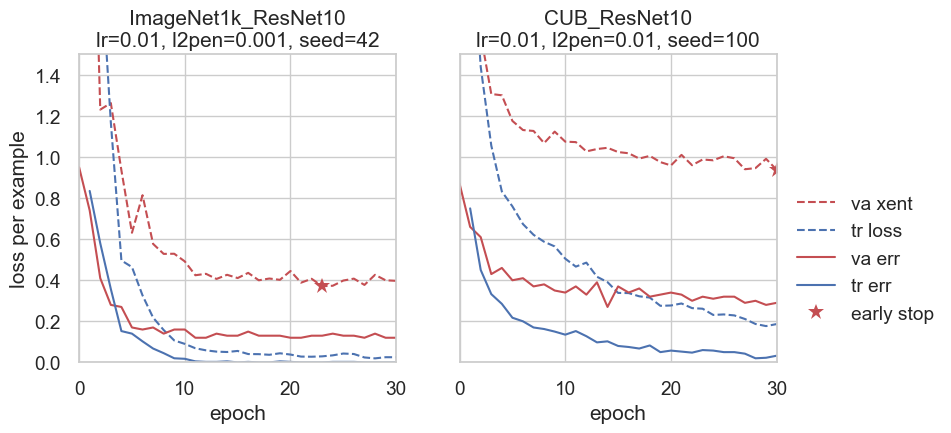

In [37]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True, sharex=False)

for panel_id, (arch, src_dataset) in enumerate([
('ImageNet1k', 'ResNet10'),
('CUB', 'ResNet10'),
        ]):
    ax = axgrid[panel_id]
    key = (arch, src_dataset)
    info = results[key][1]
    ax.plot(info['epochs'], info['va']['xent'], '--', color='r', label='va xent')
    ax.plot(info['epochs'], info['tr']['loss'], '--', color='b', label='tr loss')
    ax.plot(info['epochs'], info['va']['err'], label='va err', color='r')
    ax.plot(info['epochs'], info['tr']['err'], label='tr err', color='b')
    ax.plot(info['best_epoch'], info['best_va_loss'], '*', color='r', markersize=12, label='early stop')
    ax.set_xlabel('epoch')
    if panel_id == 0:
        ax.set_ylabel('loss per example')
    lr = info['lr']
    l2pen = info['l2pen_mag']
    seed = info['seed']
    ax.set_title(f'{arch}_{src_dataset}\nlr={lr}, l2pen={l2pen}, seed={seed}')
    ax.set_xlim([-0.001, max(info['epochs'])])

ax.set_ylim([0.0, 1.5]);
ax.legend(bbox_to_anchor=(1.55, 0.6));

## Figure 1b: Target Acc vs Source Acc

**TODO** Lookup source task accuracy (use top1 if needed) from pytorch cv webpage: https://pypi.org/project/pytorchcv/


In [38]:
src_acc = {}
src_acc[('ImageNet1k','ResNet10')] = 1 - 0.3243
src_acc[('ImageNet1k','ResNet26')] = 1 - 0.2616

src_acc[('CUB','ResNet10')] = 1 - 0.2777
src_acc[('CUB','ResNet26')] = 1- 0.2316

**TODO** Measure your best model accuracy using provided test_loader and `eval_acc` function, record values here

In [28]:
tar_acc = {}

for idx, key in enumerate([
('ImageNet1k', 'ResNet10'),
('ImageNet1k', 'ResNet26'),
('CUB', 'ResNet10'),
('CUB', 'ResNet26')
        ]):
    model, info = results[key]
    tar_acc[key] = eval_acc(model, device, test_loader)

NameError: name 'results' is not defined

: 

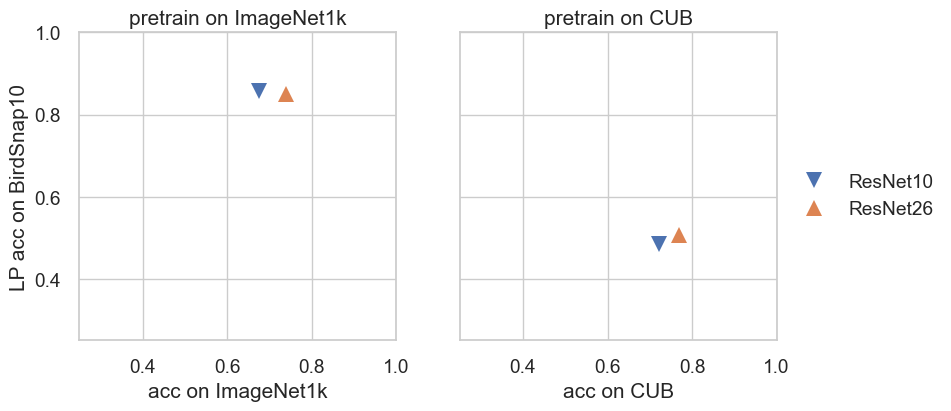

In [40]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True)

arch_list = ['ResNet10', 'ResNet26']
srcdata_list = ['ImageNet1k', 'CUB']

for (arch, src_dataset) in itertools.product(arch_list, srcdata_list):
    if src_dataset.count("ImageNet"):
        panel_id = 0
    else:
        panel_id = 1
    ax = axgrid[panel_id]
    ax.set_title("pretrain on " + src_dataset)
    key = "{arch}_{src_dataset}".format(arch=arch, src_dataset=src_dataset)
    cur_target_acc = tar_acc[(src_dataset, arch)]
    cur_src_acc = src_acc[(src_dataset, arch)]
    ax.plot(cur_src_acc, cur_target_acc, 'v' if arch.count('10') else '^', label=arch, markersize=12)
    ax.set_xlim([0.25, 1.0]); ax.set_xticks([.4, .6, .8, 1]);
    ax.set_ylim([0.25, 1.0]); ax.set_yticks([.4, .6, .8, 1]);
    ax.set_xlabel(f"acc on {src_dataset}");
    if panel_id == 0:
        ax.set_ylabel(f"LP acc on BirdSnap10");
plt.legend(bbox_to_anchor=(1.55, 0.6));

# Problem 2 Experiments

TODO Implement LP-then-FT, via repeated calls to **train_model**

* LP phase should use n_trainable_layers=1 (about 5000 trainable params)
* FT phase should use n_trainable_layers=3 (about 100000 trainable params)

In [41]:
import copy

In [47]:
P2_results = dict()

# Linear Probing Phase
n_trainable_layers_lp = 1  # Only the last layer is trainable
seed = best_info_rn10_in['seed']  # Ensure reproducibility

# Initialize the pre-trained model with only the last layer trainable
resnet10_in = models.PretrainedResNetForBirdSnap10(
    src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=n_trainable_layers_lp, seed=seed
)

# Phase 1: Linear Probing (LP)
print("Starting Linear Probing (LP) Phase...")
best_model_lp, best_info_lp = train.train_model(
    resnet10_in, device, train_loader, val_loader,
    n_epochs=30, 
    lr=best_info_rn10_in['lr'],
    l2pen_mag=best_info_rn10_in['l2pen_mag'],
    data_order_seed=seed,
)

torch.save(best_model_lp.state_dict(), 'linear_probing_model.pth')
P2_results[('ResNet10', 'ImageNet1k', 'phase1')] = best_info_lp

Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.
Starting Linear Probing (LP) Phase...


100%|██████████| 31/31 [00:26<00:00,  1.19it/s, tr_xent=0.0251, tr_err=0, va_xent=0.397, va_err=0.12, batch_done=7]     


Finished after epoch 30, best epoch=23
best va_xent 0.371
best tr_err 0.000
best va_err 0.130


In [55]:
print(len(train_loader))

7


In [44]:
# Define hyperparameter search space
learning_rates = [0.0001, 0.001, 0.01]
l2pen_mags = [0.0001, 0.001, 0.01]
seeds = [42, 100, 123]
epochs = [30, 50, 100]

# Track best model
best_val_loss = float('inf')
best_hyperparams = None
best_model = None

n_trainable_layers_ft = 3  # Fine-tune the last 3 layers

# Loop through all combinations of hyperparameters
for lr, l2pen_mag, seed, epoch in itertools.product(learning_rates, l2pen_mags, seeds, epochs):
    print(f"Training with lr={lr}, l2pen_mag={l2pen_mag}, seed={seed}, epoch={epoch}")
        
    lp_model_copy = copy.deepcopy(best_model_lp)

    # Save the model from the linear probing phase
    # Fine-Tuning Phase
    resnet10_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=n_trainable_layers_ft, seed=seed
    )

    # Load the model from the Linear Probing phase
    resnet10_in.load_state_dict(lp_model_copy.state_dict())

    # Phase 2: Fine-Tuning (FT)
    print("Starting Fine-Tuning (FT) Phase...")
    current_model_ft, current_info_ft = train.train_model(
        resnet10_in, device, train_loader, val_loader,
        n_epochs=epoch,  # Fine-tune for more epochs if needed
        lr=lr,    # Lower learning rate for fine-tuning
        l2pen_mag=l2pen_mag,  # Small L2 regularization to prevent overfitting
        data_order_seed=seed,
    )

    # Get validation loss from training info
    val_loss = min(current_info_ft['va']['xent'])
    
    # Update the best model if the current one is better
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_hyperparams = {'lr': lr, 'l2pen_mag': l2pen_mag, 'seed': seed, 'epoch': epoch}
        best_model_ft = current_model_ft

# Output the best hyperparameters and validation loss
print(f"Best validation loss: {best_val_loss}")
print(f"Best hyperparameters: {best_hyperparams}")

Training with lr=0.0001, l2pen_mag=0.0001, seed=42, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 90%|█████████ | 28/31 [00:23<00:02,  1.17it/s, tr_xent=0.008, tr_err=0, va_xent=0.371, va_err=0.12, batch_done=7]      


Stopped early.
Finished after epoch 28, best epoch=13
best va_xent 0.366
best tr_err 0.000
best va_err 0.120
Training with lr=0.0001, l2pen_mag=0.0001, seed=42, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 55%|█████▍    | 28/51 [00:23<00:19,  1.17it/s, tr_xent=0.008, tr_err=0, va_xent=0.371, va_err=0.12, batch_done=7]      


Stopped early.
Finished after epoch 28, best epoch=13
best va_xent 0.366
best tr_err 0.000
best va_err 0.120
Training with lr=0.0001, l2pen_mag=0.0001, seed=42, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 28%|██▊       | 28/101 [00:23<01:02,  1.18it/s, tr_xent=0.008, tr_err=0, va_xent=0.371, va_err=0.12, batch_done=7]      


Stopped early.
Finished after epoch 28, best epoch=13
best va_xent 0.366
best tr_err 0.000
best va_err 0.120
Training with lr=0.0001, l2pen_mag=0.0001, seed=100, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 48%|████▊     | 15/31 [00:12<00:13,  1.15it/s, tr_xent=0.0113, tr_err=0, va_xent=0.388, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.0001, l2pen_mag=0.0001, seed=100, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 29%|██▉       | 15/51 [00:12<00:30,  1.18it/s, tr_xent=0.0113, tr_err=0, va_xent=0.388, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.0001, l2pen_mag=0.0001, seed=100, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 15%|█▍        | 15/101 [00:12<01:13,  1.16it/s, tr_xent=0.0113, tr_err=0, va_xent=0.388, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.0001, l2pen_mag=0.0001, seed=123, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 48%|████▊     | 15/31 [00:13<00:13,  1.15it/s, tr_xent=0.0113, tr_err=0, va_xent=0.374, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.0001, l2pen_mag=0.0001, seed=123, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 29%|██▉       | 15/51 [00:13<00:31,  1.15it/s, tr_xent=0.0113, tr_err=0, va_xent=0.374, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.0001, l2pen_mag=0.0001, seed=123, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 15%|█▍        | 15/101 [00:12<01:14,  1.15it/s, tr_xent=0.0113, tr_err=0, va_xent=0.374, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.0001, l2pen_mag=0.001, seed=42, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 90%|█████████ | 28/31 [00:24<00:02,  1.16it/s, tr_xent=0.008, tr_err=0, va_xent=0.371, va_err=0.12, batch_done=7]      


Stopped early.
Finished after epoch 28, best epoch=13
best va_xent 0.366
best tr_err 0.000
best va_err 0.120
Training with lr=0.0001, l2pen_mag=0.001, seed=42, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 55%|█████▍    | 28/51 [00:24<00:19,  1.17it/s, tr_xent=0.008, tr_err=0, va_xent=0.371, va_err=0.12, batch_done=7]      


Stopped early.
Finished after epoch 28, best epoch=13
best va_xent 0.366
best tr_err 0.000
best va_err 0.120
Training with lr=0.0001, l2pen_mag=0.001, seed=42, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 28%|██▊       | 28/101 [00:24<01:03,  1.16it/s, tr_xent=0.008, tr_err=0, va_xent=0.371, va_err=0.12, batch_done=7]      


Stopped early.
Finished after epoch 28, best epoch=13
best va_xent 0.366
best tr_err 0.000
best va_err 0.120
Training with lr=0.0001, l2pen_mag=0.001, seed=100, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 48%|████▊     | 15/31 [00:12<00:13,  1.16it/s, tr_xent=0.0113, tr_err=0, va_xent=0.388, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.0001, l2pen_mag=0.001, seed=100, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 29%|██▉       | 15/51 [00:13<00:31,  1.15it/s, tr_xent=0.0113, tr_err=0, va_xent=0.388, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.0001, l2pen_mag=0.001, seed=100, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 15%|█▍        | 15/101 [00:13<01:14,  1.15it/s, tr_xent=0.0113, tr_err=0, va_xent=0.388, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.0001, l2pen_mag=0.001, seed=123, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 48%|████▊     | 15/31 [00:13<00:13,  1.15it/s, tr_xent=0.0113, tr_err=0, va_xent=0.374, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.0001, l2pen_mag=0.001, seed=123, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 29%|██▉       | 15/51 [00:13<00:31,  1.14it/s, tr_xent=0.0113, tr_err=0, va_xent=0.374, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.0001, l2pen_mag=0.001, seed=123, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 15%|█▍        | 15/101 [00:13<01:14,  1.15it/s, tr_xent=0.0113, tr_err=0, va_xent=0.374, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.0001, l2pen_mag=0.01, seed=42, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 90%|█████████ | 28/31 [00:23<00:02,  1.17it/s, tr_xent=0.008, tr_err=0, va_xent=0.371, va_err=0.12, batch_done=7]      


Stopped early.
Finished after epoch 28, best epoch=13
best va_xent 0.366
best tr_err 0.000
best va_err 0.120
Training with lr=0.0001, l2pen_mag=0.01, seed=42, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 55%|█████▍    | 28/51 [00:24<00:19,  1.16it/s, tr_xent=0.008, tr_err=0, va_xent=0.371, va_err=0.12, batch_done=7]      


Stopped early.
Finished after epoch 28, best epoch=13
best va_xent 0.366
best tr_err 0.000
best va_err 0.120
Training with lr=0.0001, l2pen_mag=0.01, seed=42, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 28%|██▊       | 28/101 [00:24<01:02,  1.16it/s, tr_xent=0.008, tr_err=0, va_xent=0.371, va_err=0.12, batch_done=7]      


Stopped early.
Finished after epoch 28, best epoch=13
best va_xent 0.366
best tr_err 0.000
best va_err 0.120
Training with lr=0.0001, l2pen_mag=0.01, seed=100, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 48%|████▊     | 15/31 [00:13<00:13,  1.15it/s, tr_xent=0.0113, tr_err=0, va_xent=0.388, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.0001, l2pen_mag=0.01, seed=100, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 29%|██▉       | 15/51 [00:12<00:30,  1.17it/s, tr_xent=0.0113, tr_err=0, va_xent=0.388, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.0001, l2pen_mag=0.01, seed=100, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 15%|█▍        | 15/101 [00:13<01:15,  1.14it/s, tr_xent=0.0113, tr_err=0, va_xent=0.388, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.0001, l2pen_mag=0.01, seed=123, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 48%|████▊     | 15/31 [00:13<00:14,  1.11it/s, tr_xent=0.0113, tr_err=0, va_xent=0.374, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.0001, l2pen_mag=0.01, seed=123, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 29%|██▉       | 15/51 [00:13<00:31,  1.13it/s, tr_xent=0.0113, tr_err=0, va_xent=0.374, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.0001, l2pen_mag=0.01, seed=123, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 15%|█▍        | 15/101 [00:13<01:15,  1.14it/s, tr_xent=0.0113, tr_err=0, va_xent=0.374, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.001, l2pen_mag=0.0001, seed=42, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


100%|██████████| 31/31 [00:26<00:00,  1.19it/s, tr_xent=0.00118, tr_err=0, va_xent=0.399, va_err=0.11, batch_done=7]


Finished after epoch 30, best epoch=24
best va_xent 0.342
best tr_err 0.000
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.0001, seed=42, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 76%|███████▋  | 39/51 [00:33<00:10,  1.17it/s, tr_xent=0.000967, tr_err=0, va_xent=0.392, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 39, best epoch=24
best va_xent 0.342
best tr_err 0.000
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.0001, seed=42, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 39%|███▊      | 39/101 [00:34<00:54,  1.15it/s, tr_xent=0.000967, tr_err=0, va_xent=0.392, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 39, best epoch=24
best va_xent 0.342
best tr_err 0.000
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.0001, seed=100, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 52%|█████▏    | 16/31 [00:13<00:12,  1.17it/s, tr_xent=0.00161, tr_err=0, va_xent=0.4, va_err=0.12, batch_done=7]     


Stopped early.
Finished after epoch 16, best epoch=1
best va_xent 0.362
best tr_err 0.003
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.0001, seed=100, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 31%|███▏      | 16/51 [00:13<00:29,  1.21it/s, tr_xent=0.00161, tr_err=0, va_xent=0.4, va_err=0.12, batch_done=7]     


Stopped early.
Finished after epoch 16, best epoch=1
best va_xent 0.362
best tr_err 0.003
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.0001, seed=100, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 16%|█▌        | 16/101 [00:14<01:15,  1.13it/s, tr_xent=0.00161, tr_err=0, va_xent=0.4, va_err=0.12, batch_done=7]     


Stopped early.
Finished after epoch 16, best epoch=1
best va_xent 0.362
best tr_err 0.003
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.0001, seed=123, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 55%|█████▍    | 17/31 [00:15<00:12,  1.11it/s, tr_xent=0.00193, tr_err=0, va_xent=0.396, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 17, best epoch=2
best va_xent 0.325
best tr_err 0.000
best va_err 0.110
Training with lr=0.001, l2pen_mag=0.0001, seed=123, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 33%|███▎      | 17/51 [00:13<00:26,  1.27it/s, tr_xent=0.00193, tr_err=0, va_xent=0.396, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 17, best epoch=2
best va_xent 0.325
best tr_err 0.000
best va_err 0.110
Training with lr=0.001, l2pen_mag=0.0001, seed=123, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 17%|█▋        | 17/101 [00:14<01:13,  1.14it/s, tr_xent=0.00193, tr_err=0, va_xent=0.396, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 17, best epoch=2
best va_xent 0.325
best tr_err 0.000
best va_err 0.110
Training with lr=0.001, l2pen_mag=0.001, seed=42, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


100%|██████████| 31/31 [00:25<00:00,  1.20it/s, tr_xent=0.00118, tr_err=0, va_xent=0.399, va_err=0.11, batch_done=7]


Finished after epoch 30, best epoch=24
best va_xent 0.342
best tr_err 0.000
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.001, seed=42, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 76%|███████▋  | 39/51 [00:33<00:10,  1.15it/s, tr_xent=0.000967, tr_err=0, va_xent=0.392, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 39, best epoch=24
best va_xent 0.342
best tr_err 0.000
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.001, seed=42, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 39%|███▊      | 39/101 [00:32<00:52,  1.19it/s, tr_xent=0.000967, tr_err=0, va_xent=0.392, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 39, best epoch=24
best va_xent 0.342
best tr_err 0.000
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.001, seed=100, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 52%|█████▏    | 16/31 [00:14<00:13,  1.13it/s, tr_xent=0.00161, tr_err=0, va_xent=0.4, va_err=0.12, batch_done=7]     


Stopped early.
Finished after epoch 16, best epoch=1
best va_xent 0.362
best tr_err 0.003
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.001, seed=100, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 31%|███▏      | 16/51 [00:13<00:29,  1.18it/s, tr_xent=0.00161, tr_err=0, va_xent=0.4, va_err=0.12, batch_done=7]     


Stopped early.
Finished after epoch 16, best epoch=1
best va_xent 0.362
best tr_err 0.003
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.001, seed=100, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 16%|█▌        | 16/101 [00:14<01:15,  1.12it/s, tr_xent=0.00161, tr_err=0, va_xent=0.4, va_err=0.12, batch_done=7]     


Stopped early.
Finished after epoch 16, best epoch=1
best va_xent 0.362
best tr_err 0.003
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.001, seed=123, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 55%|█████▍    | 17/31 [00:15<00:12,  1.13it/s, tr_xent=0.00193, tr_err=0, va_xent=0.395, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 17, best epoch=2
best va_xent 0.325
best tr_err 0.000
best va_err 0.110
Training with lr=0.001, l2pen_mag=0.001, seed=123, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 33%|███▎      | 17/51 [00:14<00:29,  1.14it/s, tr_xent=0.00193, tr_err=0, va_xent=0.396, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 17, best epoch=2
best va_xent 0.325
best tr_err 0.000
best va_err 0.110
Training with lr=0.001, l2pen_mag=0.001, seed=123, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 17%|█▋        | 17/101 [00:14<01:12,  1.16it/s, tr_xent=0.00193, tr_err=0, va_xent=0.396, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 17, best epoch=2
best va_xent 0.325
best tr_err 0.000
best va_err 0.110
Training with lr=0.001, l2pen_mag=0.01, seed=42, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


100%|██████████| 31/31 [00:26<00:00,  1.18it/s, tr_xent=0.00118, tr_err=0, va_xent=0.399, va_err=0.11, batch_done=7]


Finished after epoch 30, best epoch=24
best va_xent 0.342
best tr_err 0.000
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.01, seed=42, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 76%|███████▋  | 39/51 [00:34<00:10,  1.13it/s, tr_xent=0.000967, tr_err=0, va_xent=0.392, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 39, best epoch=24
best va_xent 0.342
best tr_err 0.000
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.01, seed=42, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 39%|███▊      | 39/101 [00:34<00:55,  1.12it/s, tr_xent=0.000967, tr_err=0, va_xent=0.392, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 39, best epoch=24
best va_xent 0.342
best tr_err 0.000
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.01, seed=100, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 52%|█████▏    | 16/31 [00:14<00:13,  1.12it/s, tr_xent=0.00161, tr_err=0, va_xent=0.4, va_err=0.12, batch_done=7]     


Stopped early.
Finished after epoch 16, best epoch=1
best va_xent 0.362
best tr_err 0.003
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.01, seed=100, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 31%|███▏      | 16/51 [00:14<00:30,  1.13it/s, tr_xent=0.00161, tr_err=0, va_xent=0.4, va_err=0.12, batch_done=7]     


Stopped early.
Finished after epoch 16, best epoch=1
best va_xent 0.362
best tr_err 0.003
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.01, seed=100, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 16%|█▌        | 16/101 [00:13<01:13,  1.15it/s, tr_xent=0.00161, tr_err=0, va_xent=0.4, va_err=0.12, batch_done=7]     


Stopped early.
Finished after epoch 16, best epoch=1
best va_xent 0.362
best tr_err 0.003
best va_err 0.120
Training with lr=0.001, l2pen_mag=0.01, seed=123, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 55%|█████▍    | 17/31 [00:15<00:12,  1.12it/s, tr_xent=0.00193, tr_err=0, va_xent=0.396, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 17, best epoch=2
best va_xent 0.325
best tr_err 0.000
best va_err 0.110
Training with lr=0.001, l2pen_mag=0.01, seed=123, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 33%|███▎      | 17/51 [00:15<00:30,  1.10it/s, tr_xent=0.00193, tr_err=0, va_xent=0.396, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 17, best epoch=2
best va_xent 0.325
best tr_err 0.000
best va_err 0.110
Training with lr=0.001, l2pen_mag=0.01, seed=123, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 17%|█▋        | 17/101 [00:15<01:15,  1.12it/s, tr_xent=0.00193, tr_err=0, va_xent=0.396, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 17, best epoch=2
best va_xent 0.325
best tr_err 0.000
best va_err 0.110
Training with lr=0.01, l2pen_mag=0.0001, seed=42, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 74%|███████▍  | 23/31 [00:23<00:08,  1.01s/it, tr_xent=0.000707, tr_err=0, va_xent=0.372, va_err=0.11, batch_done=7]  


Stopped early.
Finished after epoch 23, best epoch=8
best va_xent 0.340
best tr_err 0.000
best va_err 0.080
Training with lr=0.01, l2pen_mag=0.0001, seed=42, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 45%|████▌     | 23/51 [00:21<00:26,  1.07it/s, tr_xent=0.000707, tr_err=0, va_xent=0.372, va_err=0.11, batch_done=7]  


Stopped early.
Finished after epoch 23, best epoch=8
best va_xent 0.340
best tr_err 0.000
best va_err 0.080
Training with lr=0.01, l2pen_mag=0.0001, seed=42, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 23%|██▎       | 23/101 [00:21<01:11,  1.09it/s, tr_xent=0.000707, tr_err=0, va_xent=0.372, va_err=0.11, batch_done=7]  


Stopped early.
Finished after epoch 23, best epoch=8
best va_xent 0.340
best tr_err 0.000
best va_err 0.080
Training with lr=0.01, l2pen_mag=0.0001, seed=100, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 48%|████▊     | 15/31 [00:14<00:15,  1.06it/s, tr_xent=0.0012, tr_err=0, va_xent=0.455, va_err=0.12, batch_done=7]    


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.0001, seed=100, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 29%|██▉       | 15/51 [00:13<00:33,  1.09it/s, tr_xent=0.0012, tr_err=0, va_xent=0.455, va_err=0.12, batch_done=7]    


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.0001, seed=100, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 15%|█▍        | 15/101 [00:13<01:17,  1.10it/s, tr_xent=0.0012, tr_err=0, va_xent=0.455, va_err=0.12, batch_done=7]    


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.0001, seed=123, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 48%|████▊     | 15/31 [00:13<00:14,  1.13it/s, tr_xent=0.00142, tr_err=0, va_xent=0.507, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.0001, seed=123, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 29%|██▉       | 15/51 [00:14<00:33,  1.06it/s, tr_xent=0.00142, tr_err=0, va_xent=0.507, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.0001, seed=123, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 15%|█▍        | 15/101 [00:13<01:18,  1.10it/s, tr_xent=0.00142, tr_err=0, va_xent=0.507, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.001, seed=42, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 74%|███████▍  | 23/31 [00:20<00:07,  1.10it/s, tr_xent=0.000707, tr_err=0, va_xent=0.372, va_err=0.11, batch_done=7]  


Stopped early.
Finished after epoch 23, best epoch=8
best va_xent 0.340
best tr_err 0.000
best va_err 0.080
Training with lr=0.01, l2pen_mag=0.001, seed=42, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 45%|████▌     | 23/51 [00:20<00:25,  1.11it/s, tr_xent=0.000707, tr_err=0, va_xent=0.372, va_err=0.11, batch_done=7]  


Stopped early.
Finished after epoch 23, best epoch=8
best va_xent 0.340
best tr_err 0.000
best va_err 0.080
Training with lr=0.01, l2pen_mag=0.001, seed=42, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 23%|██▎       | 23/101 [00:21<01:13,  1.06it/s, tr_xent=0.000707, tr_err=0, va_xent=0.372, va_err=0.11, batch_done=7]  


Stopped early.
Finished after epoch 23, best epoch=8
best va_xent 0.340
best tr_err 0.000
best va_err 0.080
Training with lr=0.01, l2pen_mag=0.001, seed=100, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 48%|████▊     | 15/31 [00:14<00:15,  1.05it/s, tr_xent=0.0012, tr_err=0, va_xent=0.455, va_err=0.12, batch_done=7]    


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.001, seed=100, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 29%|██▉       | 15/51 [00:13<00:33,  1.09it/s, tr_xent=0.0012, tr_err=0, va_xent=0.455, va_err=0.12, batch_done=7]    


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.001, seed=100, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 15%|█▍        | 15/101 [00:14<01:20,  1.07it/s, tr_xent=0.0012, tr_err=0, va_xent=0.455, va_err=0.12, batch_done=7]    


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.001, seed=123, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 48%|████▊     | 15/31 [00:14<00:14,  1.07it/s, tr_xent=0.00142, tr_err=0, va_xent=0.507, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.001, seed=123, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 29%|██▉       | 15/51 [00:13<00:32,  1.09it/s, tr_xent=0.00142, tr_err=0, va_xent=0.507, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.001, seed=123, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 15%|█▍        | 15/101 [00:13<01:18,  1.09it/s, tr_xent=0.00142, tr_err=0, va_xent=0.507, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.01, seed=42, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 74%|███████▍  | 23/31 [00:21<00:07,  1.08it/s, tr_xent=0.000706, tr_err=0, va_xent=0.373, va_err=0.11, batch_done=7]  


Stopped early.
Finished after epoch 23, best epoch=8
best va_xent 0.339
best tr_err 0.000
best va_err 0.080
Training with lr=0.01, l2pen_mag=0.01, seed=42, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 45%|████▌     | 23/51 [00:21<00:25,  1.08it/s, tr_xent=0.000706, tr_err=0, va_xent=0.373, va_err=0.11, batch_done=7]  


Stopped early.
Finished after epoch 23, best epoch=8
best va_xent 0.339
best tr_err 0.000
best va_err 0.080
Training with lr=0.01, l2pen_mag=0.01, seed=42, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 23%|██▎       | 23/101 [00:21<01:12,  1.08it/s, tr_xent=0.000706, tr_err=0, va_xent=0.373, va_err=0.11, batch_done=7]  


Stopped early.
Finished after epoch 23, best epoch=8
best va_xent 0.339
best tr_err 0.000
best va_err 0.080
Training with lr=0.01, l2pen_mag=0.01, seed=100, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 48%|████▊     | 15/31 [00:14<00:15,  1.05it/s, tr_xent=0.0012, tr_err=0, va_xent=0.457, va_err=0.12, batch_done=7]   


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.01, seed=100, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 29%|██▉       | 15/51 [00:13<00:33,  1.08it/s, tr_xent=0.0012, tr_err=0, va_xent=0.457, va_err=0.12, batch_done=7]   


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.01, seed=100, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 15%|█▍        | 15/101 [00:13<01:18,  1.10it/s, tr_xent=0.0012, tr_err=0, va_xent=0.457, va_err=0.12, batch_done=7]   


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.01, seed=123, epoch=30
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 48%|████▊     | 15/31 [00:13<00:14,  1.09it/s, tr_xent=0.00142, tr_err=0, va_xent=0.506, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.01, seed=123, epoch=50
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 29%|██▉       | 15/51 [00:13<00:33,  1.09it/s, tr_xent=0.00142, tr_err=0, va_xent=0.506, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Training with lr=0.01, l2pen_mag=0.01, seed=123, epoch=100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 15%|█▍        | 15/101 [00:13<01:19,  1.08it/s, tr_xent=0.00142, tr_err=0, va_xent=0.506, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.371
best tr_err nan
best va_err 0.130
Best validation loss: 0.3253696441650391
Best hyperparameters: {'lr': 0.001, 'l2pen_mag': 0.01, 'seed': 123, 'epoch': 30}


In [48]:
if PROB2_EXPERIMENTS:
    lp_model_copy = copy.deepcopy(best_model_lp)

    seed = 123
    resnet10_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=n_trainable_layers_ft, seed=seed
    )

    # Load the model from the Linear Probing phase
    resnet10_in.load_state_dict(lp_model_copy.state_dict())

    # Phase 2: Fine-Tuning (FT)
    print("Starting Fine-Tuning (FT) Phase...")
    best_model_lpft, best_info_lpft = train.train_model(
        resnet10_in, device, train_loader, val_loader,
        n_epochs=30,  # Fine-tune for more epochs if needed
        lr=0.001,    # Lower learning rate for fine-tuning
        l2pen_mag=0.01,  # Small L2 regularization to prevent overfitting
        data_order_seed=seed,
    )

    P2_results[('ResNet10', 'ImageNet1k', 'phase2')] = best_info_lpft

Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.
Starting Fine-Tuning (FT) Phase...


 55%|█████▍    | 17/31 [00:14<00:11,  1.18it/s, tr_xent=0.00193, tr_err=0, va_xent=0.396, va_err=0.13, batch_done=7]   


Stopped early.
Finished after epoch 17, best epoch=2
best va_xent 0.325
best tr_err 0.000
best va_err 0.110


## Figure 2a: Trace plots for LP then FT

We'll be looking for:

* Clear continuity in val set perf (the FT phase started at val set err rate/xent of the best LP checkpoint)
* Some kind of improvement in the FT phase, at least on train

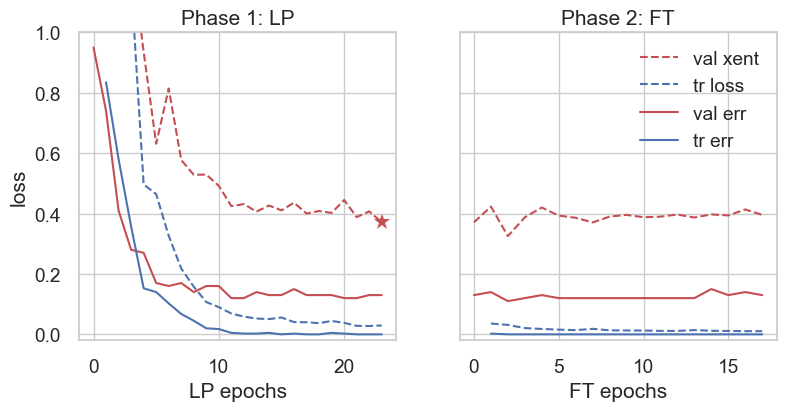

In [49]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True)

LPbest = P2_results[('ResNet10', 'ImageNet1k', 'phase1')]
FTbest = P2_results[('ResNet10', 'ImageNet1k', 'phase2')]

# Only show LP phase until early stop occurs
eps = [e for e in LPbest['epochs'] if e <= LPbest['best_epoch']]
axgrid[0].plot(eps, LPbest['va']['xent'][:len(eps)], '--', color='r', label='val xent')
axgrid[0].plot(eps, LPbest['tr']['loss'][:len(eps)], '--', color='b')
axgrid[0].plot(eps, LPbest['va']['err'][:len(eps)], color='r', label='val')
axgrid[0].plot(eps, LPbest['tr']['err'][:len(eps)], '-', color='b')
axgrid[0].plot(LPbest['best_epoch'], LPbest['best_va_loss'], '*', color='r', markersize=12);
axgrid[0].set_title("Phase 1: LP");
axgrid[0].set_xlabel("LP epochs");
axgrid[0].set_ylabel("loss");

FTeps = FTbest['epochs']
axgrid[1].plot(FTeps, FTbest['va']['xent'], '--', color='r', label='val xent')
axgrid[1].plot(FTeps, FTbest['tr']['loss'], '--', color='b', label='tr loss')
axgrid[1].plot(FTeps, FTbest['va']['err'], '-', color='r', label='val err')
axgrid[1].plot(FTeps, FTbest['tr']['err'], '-', color='b', label='tr err')
axgrid[1].set_title("Phase 2: FT");
axgrid[1].set_ylim([-0.02, 1.]);
axgrid[1].set_xlabel('FT epochs');
axgrid[1].legend(loc='upper right');

## Problem 2b: Report test-set acc for both the phase1 and phase 2

These numbers will be presented in your report.

In [52]:
# TODO compute test acc after the LP phase

print("Phase 1 accuracy: ",  eval_acc(best_model_lp, device, test_loader))

Phase 1 accuracy:  0.8571428571428571


In [53]:
# TODO compute test acc after the FT-3 phase
print("Phase 2 acc: ", eval_acc(best_model_lpft, device, test_loader))

Phase 2 acc:  0.85
